<a href="https://colab.research.google.com/github/Samuelturak/Master-s-thesis/blob/main/Official_Master_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RF signal classification with AI - Master's thesis


---

**Author: Samuel Turák**




I recommend switching to T4 GPU for performance purposes in the Runtime settings if possible.


**The structure of the code:**


1.   Imports and mounting
2.   Functions
3.   Data preprocessing - choose only 1 task there - remember to have the dataset path defined in your Google drive folder
4.   Training
5.   Evaluation - If you want to use my trained models, remember to have them
     saved on your Google Drive folder, with the specific path defined


---


Link to the datasets and models:
https://drive.google.com/drive/folders/1MnOVy8--fwdEUf94iDDMkDXsJcBdgIhk?usp=sharing

The way the filepaths in this code are structured right now requires you to download the folder "ColabNotebooks" and upload it to your Google Drive.
Your path would then be: MyDrive/ColabNotebooks/RF_classification/...

You should then have no problems in running the code!



---


For further questions contact: xturak01@vutbr.cz



# Imports and mounting





In [1]:
import pandas as pd
import numpy as np


import pickle
import h5py
import random
import os
import gc
from scipy.io import loadmat
from pandas import factorize
import itertools
from scipy import signal
import re
import glob
from keras.models import Sequential
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, ReLU, GlobalAveragePooling1D, Conv1D, AveragePooling1D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Used Functions

The code structure is inspired by:
https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb

Code snippets used from this author are cited.


## Functions to load datasets

### RMlb dataset loading

In [3]:
def load_RMLb_dataset(file_path):

    try:
        # Open the file in binary mode
        with open(file_path, 'rb') as file:
            # Attempt to unpickle the file content
            try:
                data = pickle.load(file)
            except UnicodeDecodeError:
                # If a UnicodeDecodeError occurs, try a different encoding
                file.seek(0)  # Reset file pointer to the beginning
                data = pickle.load(file, encoding='latin1')

    except Exception as e:
        print(f"An error occurred: {e}")

    # Check if data is a dictionary and print shapes of its elements
    #if isinstance(data, dict):
        #for key in data:
            #print(f"Shape of data[{key}]:", data[key].shape)
    #else:
        # If it's not a dictionary, just print the shape of data
        #print("Shape of data:", data.shape)

    X_file = []
    Y_file = []
    Z_file = []

    # Iterate through the dataset
    for (modulation, SNR), signals in data.items():
        # Append the I/Q data
        X_file.append(signals)
        # Append the modulation label for each signal in this group
        Y_file.extend([modulation] * len(signals))
        # Append the SNR value for each signal in this group
        Z_file.extend([SNR] * len(signals))

    # Convert to numpy arrays for easier handling later
    X_file = np.array(X_file)
    Y_file = np.array(Y_file)
    Z_file = np.array(Z_file)

    # Reshape X_file to merge all signal data into one array
    X_file = np.vstack(X_file)

    # Transposing
    X = X_file.transpose(0,2,1)
    #print("Shape of RMLb_X:", RMLb_X.shape)

    lbl = np.array(list(zip(Y_file, Z_file)))
    # Get number of unique SNR values
    bins = np.unique(lbl[:,1])
    num_bins = len(bins)

    mods = np.unique(lbl[:,0])
    snrs = np.unique(lbl[:,1])
    snrs = list(map(int, snrs))
    snrs.sort()

    # One-hot encoding
    Y = [];
    for i in range(len(lbl)):
        mod = (lbl[i,0])
        Y.append(mod)

    mapping = {}
    for x in range(len(mods)):
        mapping[mods[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)

    # Assign SNR value to each vector

    repeat_n = X.shape[0]/len(mods)/len(snrs)
    repeat_n_mod = len(mods)
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_mod)


    lbl_SNR = np.array(lbl[:,1], dtype=int)

    #X = X

    return snrs, X, mods, one_hot_encode, lbl_SNR, num_bins

### Load Matlab dataset .dat file

In [4]:
def load_Matlab_dataset_dat(file_path):
# Works only for the way the dataset is created

  data = {}
  current_key = ''

  # Open and read the file
  with open(file_path, 'r') as file:
      lines = file.readlines()

  # Processing the data
  for line in lines:
      if line.startswith('Data for '):
          # This is a header line indicating a new data key
          current_key = line.strip().split(' ')[-1]  # Extract the key
          data[current_key] = []
      else:
          # This is a data line
          numbers = [float(num) for num in line.split()]
          if numbers:
              data[current_key].extend(numbers)

  # Convert lists to numpy arrays and reshape to 3-D matrices
  for key in data:
      # Convert the flat list into a numpy array
      flat_array = np.array(data[key])
      # Calculate the length of the first dimension based on the total number of elements
      num_samples = len(flat_array) // (256 * 2)
      # Reshape the array into 3-D with order to match MATLAB's format
      data[key] = flat_array.reshape((256, 2, num_samples), order='F').transpose((2, 0, 1))

  # Initialize containers
  X_file = []
  Y_file = []
  Z_file = []

  # Iterate through the dataset
  for key, signals in data.items():
      # Split the key to extract signal type and SNR
      parts = key.split('_')
      signal = parts[0]  # The signal type is the first part
      # Combine the remaining parts for SNR and handle minus sign
      SNR_str = '_'.join(parts[1:])
      # Remove non-numeric characters
      SNR_str = SNR_str.replace('_', '-')  # Replace '__' with '-' for negative SNR
      SNR_str = re.sub(r'[^\d-]', '', SNR_str)

      if SNR_str.startswith('_'):  # Check if SNR is negative
          SNR = -int(SNR_str[1:])  # Convert to negative integer
      else:
          SNR = int(SNR_str)  # Convert to integer

      # Append the I/Q data
      X_file.append(signals)
      # Append the RF signal label for each signal in this group
      Y_file.extend([signal] * len(signals))
      # Append the SNR value for each signal in this group
      Z_file.extend([SNR] * len(signals))


  # Convert to numpy arrays
  X_file = np.vstack(X_file)
  Y_file = np.array(Y_file)
  Z_file = np.array(Z_file)


  X = X_file

  lbl = np.array(list(zip(Y_file, Z_file)))
  # Get number of unique SNR values
  bins = np.unique(lbl[:,1])
  num_bins = len(bins)

  mods = np.unique(lbl[:,0])
  snrs = np.unique(lbl[:,1])
  snrs = list(map(int, snrs))
  snrs.sort()

  """
  For the one-hot encoding credit goes to":

  https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
  """

  # One-hot encoding
  Y = [];
  for i in range(len(lbl)):
      mod = (lbl[i,0])
      Y.append(mod)

  mapping = {}
  for x in range(len(mods)):
      mapping[mods[x]] = x

  ## integer representation
  for x in range(len(Y)):
      Y[x] = mapping[Y[x]]

  one_hot_encode = to_categorical(Y)


  # Assign SNR value to each vector

  repeat_n = X.shape[0]/len(mods)/len(snrs)
  repeat_n_mod = len(mods)
  lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_mod)

  lbl_SNR = np.array(lbl[:,1], dtype=int)
  #X = X


  return snrs, X, mods, one_hot_encode, lbl_SNR, num_bins



### Load Matlab dataset .h5 file

In [5]:
def load_Matlab_dataset_hdf5(file_path):
# Works only for the way the dataset is created

    with h5py.File(file_path, 'r') as file:
        X_file = []
        Y_file = []
        Z_file = []

        for key in file.keys():
            signals = np.array(file[key])

            # Correctly transpose the dimensions to get (num_samples, 256, 2)
            signals = signals.transpose((0, 2, 1))

            # Extract signal type and SNR from the key
            parts = key.split('_')
            signal = parts[0]
            SNR_str = '_'.join(parts[1:])
            SNR_str = SNR_str.replace('_', '-')
            SNR_str = re.sub(r'[^\d-]', '', SNR_str)

            SNR = -int(SNR_str[1:]) if SNR_str.startswith('_') else int(SNR_str)
            X_file.append(signals)

            Y_file.extend([signal] * len(signals))

            Z_file.extend([SNR] * len(signals))

    X_file = np.vstack(X_file)
    Y_file = np.array(Y_file)
    Z_file = np.array(Z_file)

    lbl = np.array(list(zip(Y_file, Z_file)))

    mods = np.unique(lbl[:,0])
    snrs = np.unique(lbl[:,1])
    snrs = list(map(int, snrs))
    snrs.sort()


    # One-hot encoding
    Y = [];
    for i in range(len(lbl)):
        mod = (lbl[i,0])
        Y.append(mod)

    mapping = {}
    for x in range(len(mods)):
        mapping[mods[x]] = x

    ## integer representation
    for x in range(len(Y)):
        Y[x] = mapping[Y[x]]

    one_hot_encode = to_categorical(Y)


    repeat_n = X_file.shape[0] / len(mods) / len(snrs)
    repeat_n_mod = len(mods)
    lbl_SNR = np.tile(np.repeat(snrs, repeat_n), repeat_n_mod)

    #lbl_SNR = int(lbl[:,1])
    # Keeping the order of the SNRs
    lbl_SNR = np.array(lbl[:,1], dtype=int)

    num_bins = len(np.unique(lbl_SNR))

    return snrs, X_file, mods, one_hot_encode, lbl_SNR, num_bins


## Functions for preprocessing

In [6]:
def train_test_valid_split(X, one_hot, train_split=0.7, valid_split=0.15, test_split=0.15):

    """
    Input:
        X: X data (I/Q samples)
        one_hot: one hot encoded Y data
        train_split: ratio for training data
        valid_split: ratio for validation data
        test_split: ratio for testing data

        NOTE: the ratio split must be a sum of 1!

    Output:
        train_idx: indexes from X assinged to train data
        valid_idx: indexes from X assinged to validation data
        test_idx: indexes from X assinged to test data
        X_train: X data for training
        X_valid: X data for validation
        X_test: X data for testing
        Y_train: Y data for training
        Y_valid: Y data for validation
        Y_test: Y data for testing
    """

    # Do not change the random seed to ensure reproducibility of the data split
    np.random.seed(68)

    # Get the total number of examples in the dataset
    n_examples = X.shape[0]

    # Create a randomly permuted array of indices for the dataset
    indices = np.random.permutation(n_examples)

    # Calculate the ending index for the training and validation data subset
    end_train = int(train_split * n_examples)
    end_valid = end_train + int(valid_split * n_examples)

    # Use the random indeces to obtain the subsets
    train_idx = indices[:end_train]
    valid_idx = indices[end_train:end_valid]
    # Use the remaining random indices for the test set
    test_idx = indices[end_valid:]

    # Indexing to determine splitted data
    X_train = X[train_idx]
    Y_train = one_hot[train_idx]
    X_valid = X[valid_idx]
    Y_valid = one_hot[valid_idx]
    X_test = X[test_idx]
    Y_test = one_hot[test_idx]

    return train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test


In [7]:
def normalize_data(X_train, X_valid, X_test):

    """
    Source:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb

    Input:
        X_train: raw X data for training
        X_valid: raw X data for validation
        X_test: raw X data for testing

    Output:
        X_train: normalized X data for training
        X_valid: normalized X data for validation
        X_test: normalized X data for testing

    """
    # mean-std normalization

    mean = X_train[:,:,:].mean(axis=0)  # calculating mean
    X_train[:,:,:] -= mean              # substracting with mean
    std = X_train[:,:,:].std(axis=0)    # calculating standard deviation
    X_train[:,:,:] /= std               # dividing by standard


    X_valid[:,:,:] -= mean              # substracting with mean
    X_valid[:,:,:] /= std               # dividing by standard

    X_test[:,:,:] -= mean               # substracting with mean
    X_test[:,:,:] /= std                # dividing by standard

    return X_train, X_valid, X_test


In [8]:
def return_indices_of_a(a, b):
    """
    Compare two lists a, b for same items and return indeces
    of the item in list a

    a:    List of items, its indeces will be returned
    b:    List of items to search for in list a

    Source:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
    """

    b_set = set(b)
    return [i for i, v in enumerate(a) if v in b_set]

## Functions for plotting

### Plotting Confusion Matrices

In [9]:
import matplotlib.pyplot as plt

def create_directory_for_model(base_path, model_name, dataset_version, save = True):

    """
    Creates a directory for the model if it doesn't exist and returns the path.
    """
    model_dir = os.path.join(base_path, model_name, dataset_version)
    if save and not os.path.exists(model_dir):
        os.makedirs(model_dir)
        print(f"Created directory: {model_dir}")
    return model_dir



def show_confusion_matrix(validations, predictions, matrix_snr, path, save=False):

    """
    Help function to plot and save confusion matrix

    Source:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb

    Inputs:
      validations (array): True labels.
      predictions (array): Model's predictions.
      matrix_snr (int): Signal-to-Noise Ratio value for the title (if applicable).
      path (str): Directory path to save the figures.
      save (bool): Whether to save the figure.

    Output:
      Plotted and saved confusion matrix
    """

    cm = confusion_matrix(validations, predictions)
    cm_sum = cm.sum(axis=1)[:, np.newaxis]
    cmn = np.divide(cm.astype('float'), cm_sum, where=cm_sum!=0)
    fig, ax = plt.subplots(figsize=(13,13))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f', annot_kws={"size": 23}, xticklabels=signals, yticklabels=signals)   #size of inner cells

    # Allow tittle
    if matrix_snr == None:
        title = "Confusion Matrix"
    else:
        title = f"Confusion Matrix \nSNR = {matrix_snr} dB"

    plt.title(title, fontsize=30)

    # Change the size of labels
    plt.ylabel('True Label', fontsize=40) # 20 before
    plt.xlabel('Predicted Label', fontsize=40)  # 20 before
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=25)  # increase height of labels
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=25)   # increase height of labels
    ax.tick_params(axis='both', which='major', labelsize=25)

    # Access and adjust the color bar
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=22)  # Adjust fontsize for color bar ticks

    if save:
        file_snippet = "AllSNRs" if matrix_snr is None else f"{matrix_snr}dB"
        accuracy_filename_svg = f'CM_{file_snippet}_{model_name}.svg'
        accuracy_filename_eps = f'CM_{file_snippet}_{model_name}.eps'
        accuracy_filename_png = f'CM_{file_snippet}_{model_name}.png'
        plt.tight_layout()
        plt.savefig(os.path.join(path, accuracy_filename_svg), format='svg')
        plt.savefig(os.path.join(path, accuracy_filename_png), format='png')
        plt.savefig(os.path.join(path, accuracy_filename_eps), format='eps')
        print(f"Saved CM plot for {file_snippet} to {path}")
    plt.show()




In [10]:
def All_SNR_show_confusion_matrix(X_test, model, path, save = False):
    """
    Source:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb

    Set data to generate confusion matrix for all SNR values

    Input:
      X_test:   X_test data
      model: Trained model for prediction
      path: (str) Saving path for the confusion matrices
      save (bool): Whether to save the figure.

    Output:
      Send data to help function to plot confusion matrix

    """

    prediction = model.predict(X_test)

    Y_Pred = []; Y_Test = [];

    for i in range(len(prediction[:,0])):
        Y_Pred.append(np.argmax(prediction[i,:]))
        Y_Test.append(np.argmax(Y_test[i]))


    show_confusion_matrix(Y_Test, Y_Pred, None, path, save)



In [11]:
def SNR_show_confusion_matrix(snr_list, all_SNR, X_test, model, path, save=False):

    """
    Source:

    https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb

    Plot confusion matrices for given SNR value

    Input:
      snr_list: (list) SNRs to display
      all_SNR: (array) SNRs used as input
      X_test: X_test data
      model: Trained model for prediction
      path: (str) Saving path for the confusion matrices
      save (bool): Whether to save the figure

    Output:
      Send data to help function to plot confusion matrix
    """

    for snr in snr_list:
        matrix_snr = snr
        Y_Pred = []; Y_Test = []; Y_Pred_SNR = []; Y_Test_SNR = [];
        matrix_snr_index = [];

        prediction = model.predict(X_test)

        for i in range(len(prediction[:,0])):
            Y_Pred.append(np.argmax(prediction[i,:]))
            Y_Test.append(np.argmax(Y_test[i]))

        for i in range(len(all_SNR)):
            if int(all_SNR[i]) == matrix_snr:
                matrix_snr_index.append(i)

        if not matrix_snr_index:
            print(f"No matching SNR found for {matrix_snr}")
            continue

        indeces_of_Y_test = return_indices_of_a(test_idx, matrix_snr_index)

        if not indeces_of_Y_test:
            print(f"No indices found in test_idx for SNR {matrix_snr}")
            continue

        for i in indeces_of_Y_test:
            Y_Pred_SNR.append(Y_Pred[i])
            Y_Test_SNR.append(Y_Test[i])

        if not Y_Pred_SNR or not Y_Test_SNR:
            print(f"No predictions or test labels found for SNR {matrix_snr}")
            continue

        show_confusion_matrix(Y_Test_SNR, Y_Pred_SNR, matrix_snr, path, save)


### Plotting distributions

In [12]:
def signal_distribution(signals, Y_train, Y_valid, Y_test, dataset_version, save = True):

    # Getting the data for plotting
    train_counts = np.sum(Y_train, axis=0)
    valid_counts = np.sum(Y_valid, axis=0)
    test_counts = np.sum(Y_test, axis=0)

    # Set up the bar width and positions
    x = np.arange(len(signals))
    width = 0.3

    # Plotting the data
    fig, ax = plt.subplots()
    ax.bar(x - width, train_counts, width, label='Train')
    ax.bar(x, valid_counts, width, label='Validation')
    ax.bar(x + width, test_counts, width, label='Test')
    # Set labels
    ax.set_xlabel('Signals', fontsize=15)
    ax.set_ylabel('Distribution', fontsize=15)
    ax.set_title('Signal distribution for each subset')
    ax.set_xticks(x)
    ax.set_xticklabels(signals, rotation=45)
    ax.legend()
    # Save the figure if save allowed
    if save:
        file_path = f'/content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/signal_distributions/{dataset_version}'
        os.makedirs(file_path, exist_ok=True)  # Ensure the directory exists

        plt.tight_layout()
        plt.savefig(os.path.join(file_path, f'Signal_{dataset_version}_Dist.svg'), format='svg')
        plt.savefig(os.path.join(file_path, f'Signal_{dataset_version}_Dist.png'), format='png')
        plt.savefig(os.path.join(file_path, f'Signal_{dataset_version}_Dist.eps'), format='eps')

        print(f"Saved SNR accuracy plot for {dataset_version} to {file_path}")

    plt.show()


In [13]:
def snr_distribution(train_idx, valid_idx, test_idx, all_SNR, num_bins, dataset_version, save=True):

    # Calculate smallest and biggest SNR value
    min_snr = np.min(all_SNR)
    max_snr = np.max(all_SNR)
    # Calculate step of SNRs
    bin_range = max_snr - min_snr

    # Creating bins using linspace to ensure they cover the full range of SNR values, including the max value
    bins = np.linspace(min_snr, max_snr, num_bins)
    distance = bins[1] - bins[0]
    extra_bin = max_snr + distance
    bins = np.append(bins, extra_bin)

    # Calculate the histogram data for each set
    snr_train_hist, _ = np.histogram(all_SNR[train_idx], bins=bins)
    snr_valid_hist, _ = np.histogram(all_SNR[valid_idx], bins=bins)
    snr_test_hist, _ = np.histogram(all_SNR[test_idx], bins=bins)

    # Set up the bar width and positions
    width = 0.3  # the width of the bars
    x = np.arange(len(bins) - 1)  # the label locations

    fig, ax = plt.subplots()
    ax.bar(x - width, snr_train_hist, width, label='Train')
    ax.bar(x, snr_valid_hist, width, label='Validation')
    ax.bar(x + width, snr_test_hist, width, label='Test')

    # Generate x-tick labels list
    x_tick_labels = []
    for b in bins[:-1]:
        if b.is_integer():
            label = f'{int(b)}'
        #else:
            #label = f'{b:.2f}'
        x_tick_labels.append(label)

    # Setting the formatted x-tick labels
    ax.set_xticks(x)
    ax.set_xticklabels(x_tick_labels, rotation=45)
    # Setting title and labels
    ax.set_title('SNR distribution for each subset')
    ax.set_xlabel('SNR [dB]', fontsize=15)
    ax.set_ylabel('Distribution', fontsize=15)
    ax.legend()
    # Save if it is allowed
    if save:
        file_path = f'/content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/snr_distributions/{dataset_version}'
        os.makedirs(file_path, exist_ok=True)  # Ensure the directory exists

        plt.tight_layout()
        plt.savefig(os.path.join(file_path, f'SNR_{dataset_version}_Dist.svg'), format='svg')
        plt.savefig(os.path.join(file_path, f'SNR_{dataset_version}_Dist.png'), format='png')
        plt.savefig(os.path.join(file_path, f'SNR_{dataset_version}_Dist.eps'), format='eps')

        print(f"Saved SNR accuracy plot for {dataset_version} to {file_path}")

    plt.show()


### Plotting accuracy

In [14]:
def SNR_accuracy(snr_list, names, num_bins, test_idx, all_SNR, X_test, Y_test, models, dataset_version, save = True):
    """
    Computes and plots accuracies of chosen SNRs for multiple models.

    Input:
      in_snr (list): List of SNRs to evaluate
      names (list of str): Labels for each model for the plot
      num_bins (int): Number of bins for plotting
      test_idx (array): Indices of the test samples
      all_SNR (array): SNR labels for each test sample
      X_test (array): Test features
      Y_test (array): Test labels
      models (list of Models): Keras models to evaluate
      dataset_version: On which dataset version the models are being evaluated
      save (bool): Whether to save the figure

    Output:
      numpy.array: Array of accuracies for each SNR
    """

    # Calculate smallest and biggest SNR value
    min_snr = np.min(snr_list)
    max_snr = np.max(snr_list)

    # Calculate SNR step, used for plotting
    bins = np.linspace(min_snr, max_snr, num_bins)
    distance = bins[1] - bins[0]

    all_acc = []  # list to store accuracy data for all models

    # Loop over each model and its name
    for model, name in zip(models, names):

      acc = []    # List to store accuracies for current model

      # Evaluate accuracy for each SNR in the list
      for snr in snr_list:
          idx_acc_snr = []

          # Loop over the test indices to find matches for the current SNR
          for i in range(len(test_idx)):
              if int(all_SNR[test_idx[i]]) == int(snr):
                  idx_acc_snr.append(i)

          ## For alternative X_test arrangment
          #for i in test_idx:
              #if int(all_SNR[i]) == int(snr):
                  #idx_acc_snr.append(i)

          # remove this
          #if not idx_acc_snr:
              #print(f"No data for SNR {snr}dB")
              #continue

          # Extract the subset of X_test and Y_test that matches the current SNR
          acc_X_test = X_test[idx_acc_snr]
          acc_Y_test = Y_test[idx_acc_snr]

          print(f'\nSNR {snr}dB:')
          # Evaluate the model
          accuracy_snr = model.evaluate(acc_X_test, acc_Y_test, batch_size=32, verbose=2)
          acc.append((snr, accuracy_snr[1]))

      # Add accuracies to the list for all models
      #if acc:
      all_acc.append((name, np.array(acc)))

    # Send accuracies to help function to plot them
    #if all_acc: # remove this
    plot_accuracy(all_acc, min_snr, max_snr, distance, dataset_version, save)
    #else:
        #print("No data available to plot.")

    #acc = np.vstack(acc)
    #plot_accuracy(acc, snr_list, name, min_snr, max_snr, distance)
    #return acc[:,1]

def plot_accuracy(all_acc_data, min_snr, max_snr, distance, dataset_version, save):
    """
    Help function to plot accuracy.

    Input:
      all_acc_data (array): Accuracies to plot
      min_snr (float): Minimum SNR value
      max_snr (float): Maximum SNR value
      distance (integer): Steps for SNR values
      dataset_version: On which dataset version the models are being evaluated
      save (bool): Whether to save the figure

    Output:
      Plotted and saved accuracy figures
    """

    #fig, ax = plt.subplots(figsize=(10, 5))
    fig, ax = plt.subplots()
    markers = itertools.cycle(['o', '^', 's', 'd', '*'])  # Create a cycling iterator for markers
    line_width = 1.5

    # Set the figure
    for name, acc in all_acc_data:
        ax.plot(acc[:, 0], acc[:, 1] * 100, label=name, marker=next(markers), linestyle='-')

    ax.set_title("Classification Accuracy by SNR", fontsize=16)
    ax.set_xlabel("SNR (dB)", fontsize=20)
    ax.set_ylabel("Accuracy (%)", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15) # set this to increase height
    ax.set_xticks(np.arange(min_snr, max_snr + 1, distance))
    ax.set_xticklabels([f'{int(s)}' for s in np.arange(min_snr, max_snr + 1, distance)], rotation=45)  # Set custom tick labels with rotation
    ax.set_ylim([0, 101])
    ax.grid(True)
    ax.legend(loc = 'lower right')
    file_path = f'/content/drive/MyDrive/ColabNotebooks/RF_classification/SNR_accuracies'
    # Save if allowed
    if save:
      os.makedirs(file_path, exist_ok=True)  # Ensure the directory exists
      plt.tight_layout()
      plt.savefig(os.path.join(file_path, f'SNR_{dataset_version}_Acc.svg'), format='svg')
      plt.savefig(os.path.join(file_path, f'SNR_{dataset_version}_Acc.png'), format='png')
      plt.savefig(os.path.join(file_path, f'SNR_{dataset_version}_Acc.eps'), format='eps')
      print(f"Saved SNR accuracy plot for {dataset_version} to {file_path}")
    plt.show()

## Functions for saving

In [15]:
def save_training_history(history, base_history_path, dataset_version, model_name, save=False):
    """
    Optionally saves training history to a file names after the dataset version.

    Input:
      history (dict or keras.callbacks.History): History object or dictionary containing the training history.
      base_history_path (str): Base directory to store history files.
      dataset_version (str): Version of the dataset, used to create a subdirectory for the history files.
      model_name (str): Name of the model, used to customize the saved history filename.
      save (bool): Whether to actually save the file or not. Default is True.

    Output:
      Saving training history
    """
    # Determine the correct history data to save
    history_data = history.history if hasattr(history, 'history') else history

    # Create the directory for this dataset's history if it doesn't exist and if save is True
    history_directory = os.path.join(base_history_path, dataset_version)
    if save:
        if not os.path.exists(history_directory):
            os.makedirs(history_directory)
            print(f"Created directory {history_directory}")

        # Create the filename based on the dataset version and model name
        model_version = dataset_version.split('_')[-1]  # Assumes format 'Dataset_vX'
        history_filename = f"{model_name}_model_{model_version}_history.pkl"
        history_filepath = os.path.join(history_directory, history_filename)

        # Save the history dictionary to a pickle file
        with open(history_filepath, 'wb') as file:
            pickle.dump(history_data, file)
        print(f"History saved successfully to {history_filepath}")
    else:
        print(f"Not saving. Directory and file creation skipped per save=False.")

In [16]:
def load_and_plot_history(base_dir, model_version, dataset_version, save=False):
    """
    Automates the process of loading and plotting training history for a given model version.
    Paths for history and plots are derived from the base directory and model version.

    Input:
      base_dir (str): Base directory where histories and plots are organized
      model_version (str): Version of the model, used to identify specific directories and files
      dataset_version (str): Version of the dataset, used to create a subdirectory for the history files.
    Output:
    - None
    """

    # Dynamically set paths and filenames
    history_dir = os.path.join(base_dir, 'Histories', dataset_version)
    plot_dir = os.path.join(base_dir, 'Figures', 'Training_progress_figs', model_version)

    # Automatically find the history file using a pattern
    history_pattern = os.path.join(history_dir, f"{model_version}_history.pkl")
    history_files = glob.glob(history_pattern)
    print(history_pattern)
    if not history_files:
        raise FileNotFoundError(f"No history files found for {model_version} in {history_dir}")
    history_file = history_files[0]  # Assuming the first file is the desired one

    # Load the history from the file
    with open(history_file, 'rb') as file:
        history = pickle.load(file)

    # Ensure the plot directory exists
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

    # Plot and save the training progress
    plot_training_progress(history, plot_dir, model_version, save)

def plot_training_progress(history, path, model_version, save):
    """
    Plots and saves training progress graphs for accuracy and loss.
    """
    # Specify file names
    accuracy_filename_svg = f'Accuracy_{model_version}.svg'
    accuracy_filename_eps = f'Accuracy_{model_version}.eps'
    accuracy_filename_png = f'Accuracy_{model_version}.png'
    loss_filename_svg = f'Loss_{model_version}.svg'
    loss_filename_eps = f'Loss_{model_version}.eps'
    loss_filename_png = f'Loss_{model_version}.png'

    plt.figure(figsize=(8,6))
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Progress During Training', fontsize=20)
    plt.xlabel('Number of Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend()
    # Save in SVG format
    if save:
      accuracy_filepath_svg = os.path.join(path, accuracy_filename_svg)
      plt.savefig(accuracy_filepath_svg, format='svg')
      print(f"Saved Accuracy plot to: {accuracy_filepath_svg}")
      # Save in EPS format
      accuracy_filepath_eps = os.path.join(path, accuracy_filename_eps)
      plt.savefig(accuracy_filepath_eps, format='eps')
      print(f"Saved Accuracy plot to: {accuracy_filepath_eps}")
      # Save in PNG format
      accuracy_filepath_png = os.path.join(path, accuracy_filename_png)
      plt.savefig(accuracy_filepath_png, format='png')
      print(f"Saved Accuracy plot to: {accuracy_filepath_png}")
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Progress During Training', fontsize=20)
    plt.xlabel('Number of Epochs', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.legend()
    if save:
      # Save in SVG format
      loss_filepath_svg = os.path.join(path, loss_filename_svg)
      plt.savefig(loss_filepath_svg, format='svg')
      print(f"Saved Loss plot to: {loss_filepath_svg}")
      # Save in EPS format
      loss_filepath_eps = os.path.join(path, loss_filename_eps)
      plt.savefig(loss_filepath_eps, format='eps')
      print(f"Saved Loss plot to: {loss_filepath_eps}")
      # Save in PNG format
      loss_filepath_png = os.path.join(path, loss_filename_png)
      plt.savefig(loss_filepath_png, format='png')
      print(f"Saved Loss plot to: {loss_filepath_png}")
    plt.show()

In [17]:
def define_model_path(model_filepath, dataset_version, name):

    # Building the pattern to find the specific GRU model file
    model_pattern = os.path.join(model_filepath, f"{name}_model_{dataset_version[8:]}.tf")  # Assumes "Dataset_vX" format
    model_files = glob.glob(model_pattern)

    # Check and handle model file selection
    if model_files:
        model_path = model_files[0]
        print(f"Model file selected: {model_path}")
    else:
        # Create a new model file path if none exist
        model_path = model_pattern
        print(f"No existing model file found. New model will be saved to: {model_path}")

    return model_path

# Data preprocessing - Choose only 1 dataset to load!













## For Matlab dataset - RF signal classification

In [18]:
#### Uncomment for choosing a dataset ####

# v1 - only AWGN dataset    -- bad results example dataset
#dataset_version = 'Dataset_v1'

# v2 - AWGN dataset
dataset_version = 'Dataset_v2'

# v4 - AWGN + phase offset + amplitude I/Q imbalance dataset
#dataset_version = 'Dataset_v4'

# v5 - AWGN + phase offset + amplitude I/Q imbalance + Rician Channel dataset
#dataset_version = 'Dataset_v5'

# v6 - AWGN + phase offset + amplitude I/Q imbalance + Rayleigh Channel dataset
#dataset_version = 'Dataset_v6'



file_path = '/content/drive/MyDrive/ColabNotebooks/RF_classification/Datasets/'

# Taking thee only .h5 file in the folder
dataset_path = glob.glob(os.path.join(file_path, dataset_version, '*.h5'))
print(dataset_path[0])
dataset_path = dataset_path[0]
version_suffix = dataset_version[8:]  # Extracts 'vX'

print(version_suffix)

# Openning the chosen dataset
SNR, X, signals, Y, lbl_SNR, num_bins = load_Matlab_dataset_hdf5(dataset_path)

#SNR - list of SNRs
#X - all the data
#signals - list of signals in strings
#Y - signals one-hot-encoded (all)
#lbl_SNR - list of SNRs (all)
#num_bins - number of SNRs



/content/drive/MyDrive/ColabNotebooks/RF_classification/Datasets/Dataset_v2/Final_dataset_v2.h5
v2


Rename signals to more convenient name

In [19]:
print(signals)
# Hardcoding formal names to the signals
signals = ["WLAN\n802.11b", "WLAN\n802.11ac", "ZigBee\n802.15.4", "Bluetooth\nBR/EDR"]
print(signals)

['WLANbg' 'WLANnac' 'Zigbee' 'bluetooth']
['WLAN\n802.11b', 'WLAN\n802.11ac', 'ZigBee\n802.15.4', 'Bluetooth\nBR/EDR']


In [20]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, Y, train_split=0.7, valid_split=0.15, test_split=0.15)

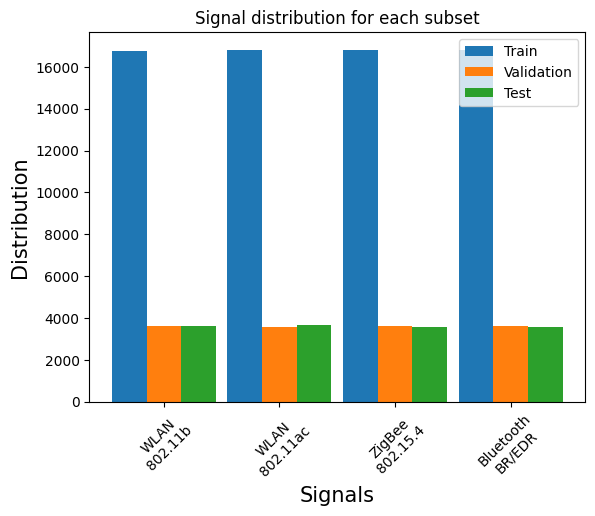

In [21]:
signal_distribution(signals, Y_train, Y_valid, Y_test, dataset_version, save = False)

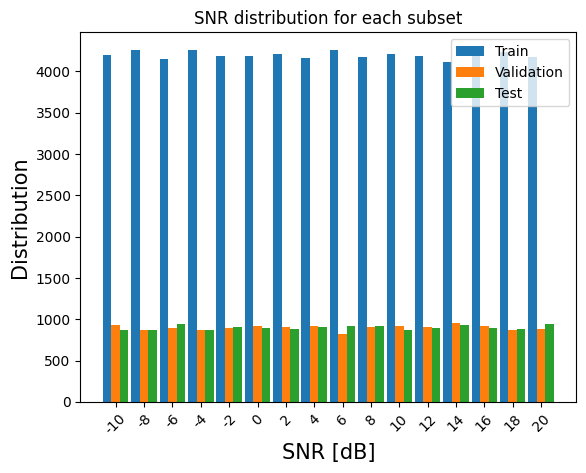

In [22]:
snr_distribution(train_idx, valid_idx, test_idx, lbl_SNR, num_bins, dataset_version, save = False)

In [23]:
X_train, X_valid, X_test = normalize_data(X_train, X_valid, X_test)

## For Matlab dataset - RF signal classification + mixed signals

In [ ]:
#### Uncomment for choosing a dataset ####


# v9 - AWGN + phase offset dataset + amplitude I/Q imbalance dataset + 7 classes -- CAN BE USED
dataset_version = 'Dataset_v9'


file_path = '/content/drive/MyDrive/ColabNotebooks/RF_classification/Datasets/'
# Taking hte only .h5 file in the folder
dataset_path = glob.glob(os.path.join(file_path, dataset_version, '*.h5'))
print(dataset_path)
print(dataset_path[0])
dataset_path = dataset_path[0]
version_suffix = dataset_version[8:]    # Extracts 'vX'
#version_suffix = dataset_version.split('_')[-1]  # Extracts 'vX'
print(version_suffix)


# Openning the chosen dataset
SNR, X, signals, Y, lbl_SNR, num_bins = load_Matlab_dataset_hdf5(dataset_path)
print(signals)



#SNR - list of SNRs
#X - all the data
#signals - list of signals in strings
#Y - signals one-hot-encoded (all)
#lbl_SNR - list of SNRs (all)
#num_bins - number of SNRs



['/content/drive/MyDrive/ColabNotebooks/RF_classification/Datasets/Dataset_v9/Final_dataset_v9.h5']
/content/drive/MyDrive/ColabNotebooks/RF_classification/Datasets/Dataset_v9/Final_dataset_v9.h5
v9
['WLANbg' 'WLANnac' 'ZigBeeWLANbg' 'Zigbee' 'bluetooth' 'bluetoothWLANbg'
 'bluetoothWLANnac']


Rename signals to more convenient name

In [ ]:
print(signals)
# Hardcoding formal names to the signals
if len(signals) == 7:
  signals = ["WLAN\n802.11b", "WLAN\n802.11ac", "ZigBee\n802.15.4 + WLAN\n802.11b", "ZigBee\n802.15.4", "Bluetooth\nBR/EDR", "Bluetooth\nBR/EDR + WLAN\n802.11b", "Bluetooth\nBR/EDR + WLAN\n802.11ac"]

print(signals)

['WLANbg' 'WLANnac' 'ZigBeeWLANbg' 'Zigbee' 'bluetooth' 'bluetoothWLANbg'
 'bluetoothWLANnac']
['WLAN\n802.11b', 'WLAN\n802.11ac', 'ZigBee\n802.15.4 + WLAN\n802.11b', 'ZigBee\n802.15.4', 'Bluetooth\nBR/EDR', 'Bluetooth\nBR/EDR + WLAN\n802.11b', 'Bluetooth\nBR/EDR + WLAN\n802.11ac']


In [ ]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, Y, train_split=0.7, valid_split=0.15, test_split=0.15)

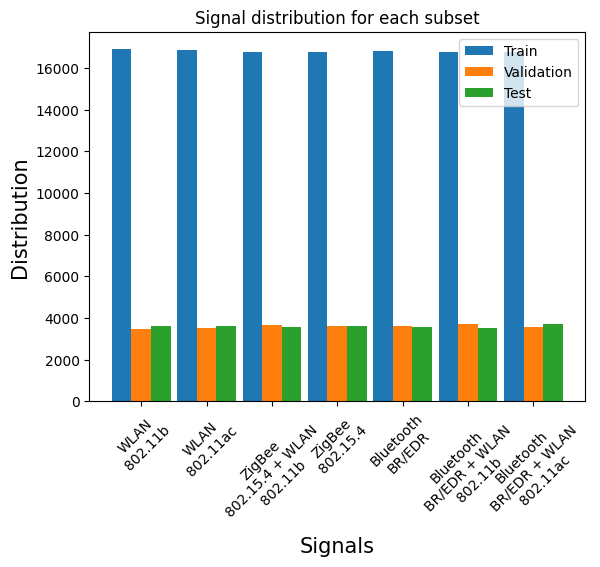

In [ ]:
signal_distribution(signals, Y_train, Y_valid, Y_test, dataset_version, save = False)

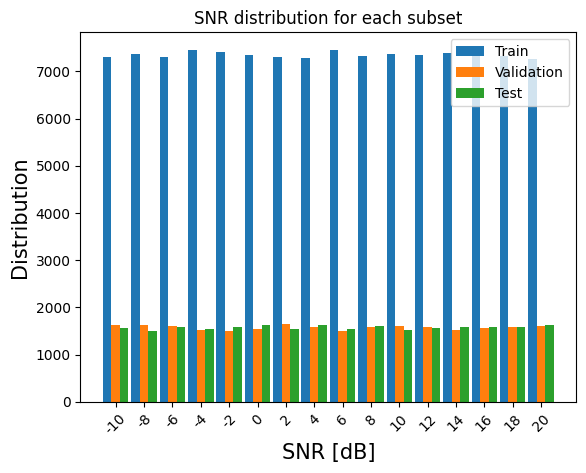

In [ ]:
snr_distribution(train_idx, valid_idx, test_idx, lbl_SNR, num_bins, dataset_version, save = False)

In [ ]:
X_train, X_valid, X_test = normalize_data(X_train, X_valid, X_test)

## For Matlab dataset - WLAN n/ac signal classification

In [ ]:
#### Uncomment for choosing a dataset ####

# v11 - AWGN + phase offset dataset + amplitude I/Q imbalance dataset
dataset_version = 'Dataset_v11'



file_path = '/content/drive/MyDrive/ColabNotebooks/RF_classification/Datasets/'
# Taking hte only .h5 file in the folder
dataset_path = glob.glob(os.path.join(file_path, dataset_version, '*.h5'))
print(dataset_path)
print(dataset_path[0])
dataset_path = dataset_path[0]
version_suffix = dataset_version[8:]    # Extracts 'vX'
#version_suffix = dataset_version.split('_')[-1]  # Extracts 'vX'
print(version_suffix)


# Openning the chosen dataset
SNR, X, signals, Y, lbl_SNR, num_bins = load_Matlab_dataset_hdf5(dataset_path)

#SNR - list of SNRs
#X - all the data
#signals - list of signals in strings
#Y - signals one-hot-encoded (all)
#lbl_SNR - list of SNRs (all)
#num_bins - number of SNRs


['/content/drive/MyDrive/ColabNotebooks/RF_classification/Datasets/Dataset_v11/Final_dataset_v11.h5']
/content/drive/MyDrive/ColabNotebooks/RF_classification/Datasets/Dataset_v11/Final_dataset_v11.h5
v11


Rename signals to more convenient name

In [ ]:
print(signals)  # There is a mistake in dataset_v11, its 256-QAM, not 64-QAM as the original label
# Hardcoding formal names to the signals
signals = ["802.11ac\nBPSK", "802.11ac\n16-QAM", "802.11ac\n256-QAM", "802.11ac\nQPSK"]
print(signals)

['WLANnacBPSK' 'WLANnacQAM16' 'WLANnacQAM256' 'WLANnacQPSK']
['802.11ac\nBPSK', '802.11ac\n16-QAM', '802.11ac\n256-QAM', '802.11ac\nQPSK']


In [ ]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, Y, train_split=0.7, valid_split=0.15, test_split=0.15)

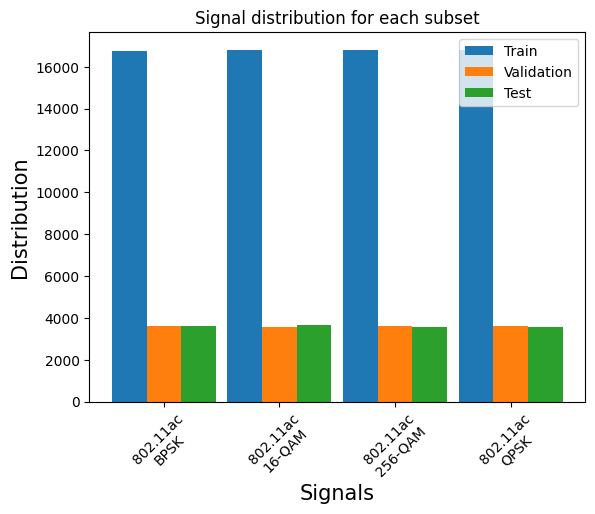

In [ ]:
signal_distribution(signals, Y_train, Y_valid, Y_test, dataset_version, save = False)

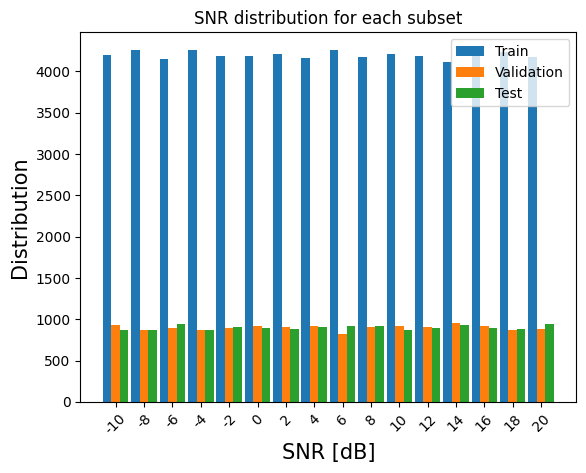

In [ ]:
snr_distribution(train_idx, valid_idx, test_idx, lbl_SNR, num_bins, dataset_version, save = False)

In [ ]:
X_train, X_valid, X_test = normalize_data(X_train, X_valid, X_test)

## RadioML Dataset 2016b - Modulation classification

*  O'shea, Timothy J., and Nathan West. "Radio machine learning dataset generation with gnu radio." Proceedings of the GNU Radio Conference. Vol. 1. No. 1. 2016.

* The datasets are available at:  https://www.deepsig.ai/datasets  

*  All datasets provided by Deepsig Inc. are licensed under the Creative Commons Attribution -  [NonCommercial - ShareAlike 4.0 License (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/).

In [ ]:
# Choose your path to the dataset
dataset_path = '/content/drive/MyDrive/ColabNotebooks/RF_classification/Datasets/Dataset_modulations/RML2016.10b.dat'

print(dataset_path)

# Hardcoding
dataset_version = 'Dataset_modulations'
version_suffix = 'modulations'

print(version_suffix)


SNR, X, signals, Y, lbl_SNR, num_bins = load_RMLb_dataset(dataset_path)

#SNR - list of SNRs
#X - all the data
#signals - list of signals in strings
#Y - signals one-hot-encoded (all)
#lbl_SNR - list of SNRs (all)
#num_bins - number of SNRs

/content/drive/MyDrive/ColabNotebooks/RF_classification/Datasets/Dataset_modulations/RML2016.10b.dat
modulations


In [ ]:
print(signals)

['8PSK' 'AM-DSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64' 'QPSK'
 'WBFM']


In [ ]:
train_idx, valid_idx, test_idx, X_train, X_valid, X_test, Y_train, Y_valid, Y_test = train_test_valid_split(X, Y, train_split=0.7, valid_split=0.15, test_split=0.15)

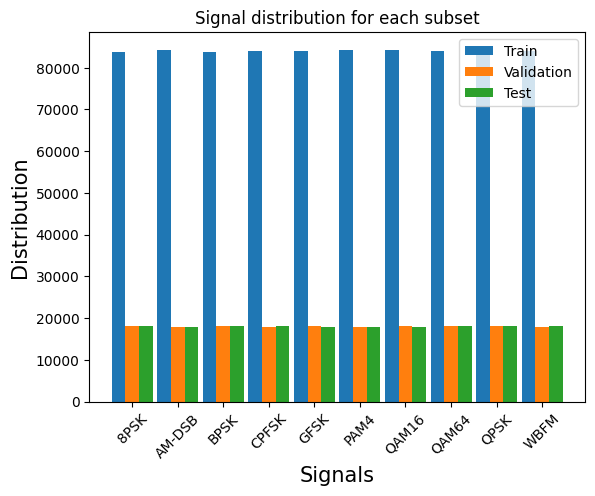

In [ ]:
signal_distribution(signals, Y_train, Y_valid, Y_test, dataset_version, save = False)

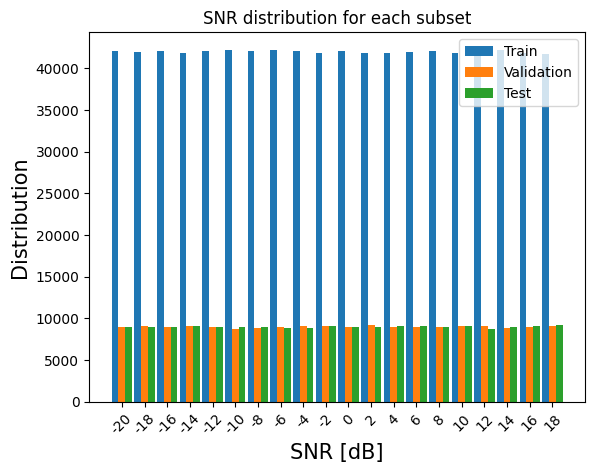

In [ ]:
snr_distribution(train_idx, valid_idx, test_idx, lbl_SNR, num_bins, dataset_version, save = False)

In [ ]:
X_train, X_valid, X_test = normalize_data(X_train, X_valid, X_test)

# Proposed models and training

## CNN

In [ ]:
"""
This neural network stems originally from:

https://github.com/KristynaPijackova/Radio-Modulation-Recognition-Networks/blob/main/Radio_Modulation_Recognition_Networks.ipynb
"""

cnn_in = keras.layers.Input(shape=(X.shape[1],2))
cnn = keras.layers.ZeroPadding1D(padding=4)(cnn_in)                                 # Adding Zero padding
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)        # Convolutional 1D layer with relu activation
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)                                      # Adding Maximum Pooling
cnn = keras.layers.Conv1D(filters=50, kernel_size=8, activation='relu')(cnn)        # Convolutional 1D layer with relu activation
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)                                      # Adding Maximum Pooling
cnn = keras.layers.Conv1D(filters=50, kernel_size=4, activation='relu')(cnn)        # Convolutional 1D layer with relu activation
cnn = keras.layers.Dropout(rate=0.6)(cnn)                                           # Adding Dopout to prevent overfitting
cnn = keras.layers.MaxPool1D(pool_size=2)(cnn)                                      # Adding Maximum Pooling
cnn = keras.layers.Flatten()(cnn)                                                   # Flattening the output
cnn = keras.layers.Dense(70, activation='selu')(cnn)                                # Adding a fully connected layer
cnn_out = keras.layers.Dense(len(signals), activation='softmax')(cnn)               # Output layer - adjust according to the number of classes in classification task

model_cnn = keras.models.Model(cnn_in, cnn_out)                                     # Finishing defining the model


# Alligning model version to dataset version
### Uncoment those lines if you want to save the models
model_base_filepath = "/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CNN"
model_path = define_model_path(model_base_filepath, dataset_version, "CNN")

# Setting hyperparameters for training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        model_path,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=0.00007),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        verbose=1)]

optimizer = keras.optimizers.Adam(learning_rate=0.0007) # 0.0007 originally

model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
model_cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 zero_padding1d_2 (ZeroPadd  (None, 136, 2)            0         
 ing1D)                                                          
                                                                 
 conv1d_6 (Conv1D)           (None, 129, 50)           850       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 64, 50)            0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 57, 50)            20050     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 28, 50)            0   

### Initialize the training process and save history.

In [ ]:
tf.keras.backend.clear_session()
#model_cnn = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_v6.tf")
history = model_cnn.fit(X_train, Y_train, batch_size=32, epochs=100, verbose=1, validation_data= (X_valid, Y_valid), callbacks=callbacks) # 32 batchsize, 4 epochs
# verbose - set at 1 shows many information, set on 2 shows less information

### Saving the histories into a folder
base_history_path = '/content/drive/MyDrive/ColabNotebooks/RF_classification/Histories'
save_training_history(history, base_history_path, dataset_version, "CNN", save = False)

# Uncomment this if you want to save the trained model into "model" variable
#model = model_cnn

Epoch 1/100
3675/3675 [==============================] - 21s 5ms/step - loss: 1.6616 - accuracy: 0.2977 - val_loss: 1.5727 - val_accuracy: 0.3360 - lr: 7.0000e-04
Epoch 2/100
3675/3675 [==============================] - 16s 4ms/step - loss: 1.3616 - accuracy: 0.4070 - val_loss: 1.2972 - val_accuracy: 0.4382 - lr: 7.0000e-04
Epoch 3/100
3675/3675 [==============================] - 16s 4ms/step - loss: 1.2868 - accuracy: 0.4305 - val_loss: 1.2796 - val_accuracy: 0.4398 - lr: 7.0000e-04
Epoch 4/100
3675/3675 [==============================] - 16s 4ms/step - loss: 1.2600 - accuracy: 0.4405 - val_loss: 1.2469 - val_accuracy: 0.4506 - lr: 7.0000e-04
Epoch 5/100
3675/3675 [==============================] - 16s 4ms/step - loss: 1.2417 - accuracy: 0.4482 - val_loss: 1.2403 - val_accuracy: 0.4467 - lr: 7.0000e-04
Epoch 6/100
3675/3675 [==============================] - 16s 4ms/step - loss: 1.2301 - accuracy: 0.4519 - val_loss: 1.2324 - val_accuracy: 0.4531 - lr: 7.0000e-04
Epoch 7/100
3675/3675 

Show training process informations on charts. History has to be saved on your drive to display.

CNN_model_v9
/content/drive/MyDrive/ColabNotebooks/RF_classification/Histories/Dataset_v9/CNN_model_v9_history.pkl


Saved Accuracy plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/CNN_model_v9/Accuracy_CNN_model_v9.svg
Saved Accuracy plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/CNN_model_v9/Accuracy_CNN_model_v9.eps
Saved Accuracy plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/CNN_model_v9/Accuracy_CNN_model_v9.png


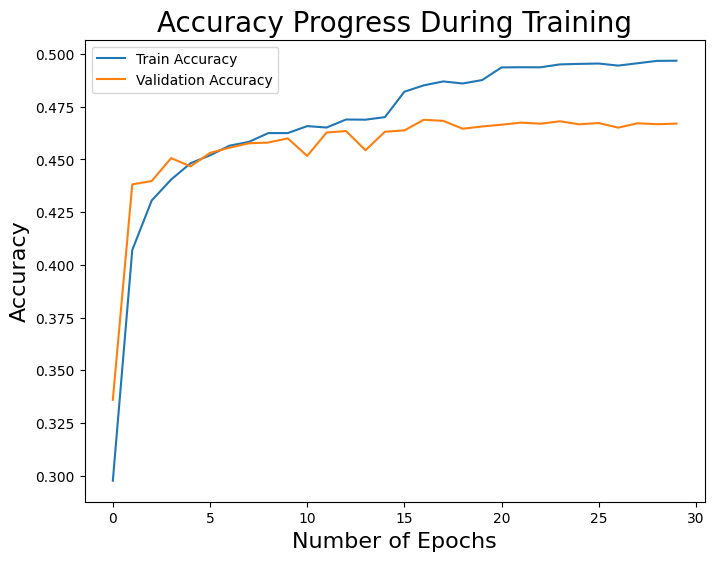

Saved Loss plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/CNN_model_v9/Loss_CNN_model_v9.svg
Saved Loss plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/CNN_model_v9/Loss_CNN_model_v9.eps
Saved Loss plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/CNN_model_v9/Loss_CNN_model_v9.png


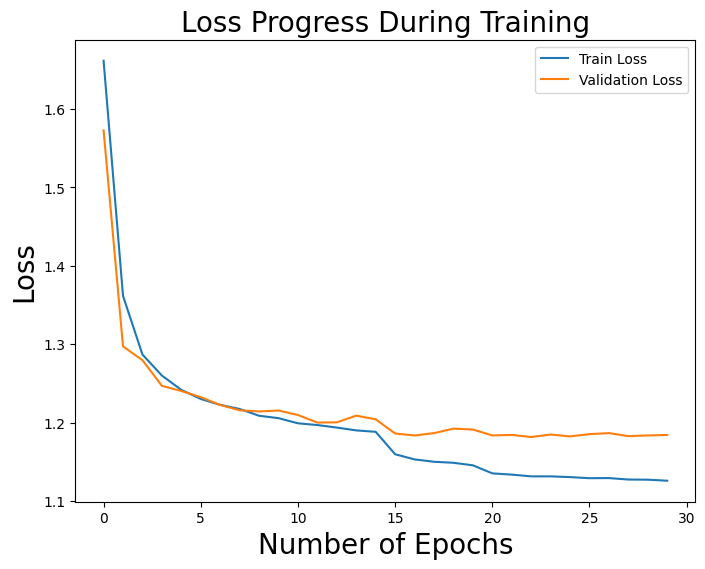

In [ ]:
# Assuming history is a dictionary loaded from a file or created manually
base_dir = f'/content/drive/MyDrive/ColabNotebooks/RF_classification/'
model_version = f"CNN_model_{version_suffix}"
print(model_version)
load_and_plot_history(base_dir, model_version, dataset_version)


##GRU


In [ ]:
"""
This neural network stems originally from:

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8322633
"""

#from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, ReLU, GlobalAveragePooling1D, Conv1D, AveragePooling1D

# Define the model
gru_in = keras.layers.Input(shape=(X.shape[1],2))
gru = keras.layers.GRU(50, return_sequences=True)(gru_in)                       # Adding a GRU layer
gru = keras.layers.Dropout(rate=0.6)(gru)                                       # Adding dropout to prevent overfitting
gru = keras.layers.GRU(50, return_sequences=True)(gru)                          # Adding a GRU layer
gru = keras.layers.Dropout(rate=0.6)(gru)                                       # Adding dropout to prevent overfitting
gru = keras.layers.Flatten()(gru)                                               # Flattening the output
gru = keras.layers.Dense(128, activation='relu')(gru)                           # Adding a fully connected layer
gru = keras.layers.Dropout(rate=0.6)(gru)                                       # Adding dropout to prevent overfitting
gru_out = keras.layers.Dense(len(signals), activation='softmax')(gru)           # Output layer - adjust according to the number of classes in classification task
model_gru = keras.models.Model(gru_in, gru_out)                                 # Finishing defining the model

# Alligning model version to dataset version
### Uncoment those lines if you want to save the models
model_base_filepath = "/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU"
model_path = define_model_path(model_base_filepath, dataset_version, "GRU")

# Setting hyperparameters for training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        model_path,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=4,
        min_lr=0.00001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)]


optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
# Compile the model
model_gru.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])




Model file selected: /content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_modulations.tf


In [ ]:
# Model summary to verify the architecture
model_gru.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 gru (GRU)                   (None, 128, 50)           8100      
                                                                 
 dropout_3 (Dropout)         (None, 128, 50)           0         
                                                                 
 gru_1 (GRU)                 (None, 128, 50)           15300     
                                                                 
 dropout_4 (Dropout)         (None, 128, 50)           0         
                                                                 
 flatten_3 (Flatten)         (None, 6400)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               8193

### Initialize the training process and save history.

In [ ]:
tf.keras.backend.clear_session()
# Uncomment to load a specific model an to continue training it, else the selected new model will overwrite it
#model_GRU = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_v6.tf")

history = model_gru.fit(X_train, Y_train, batch_size=128, epochs=100, verbose=1, validation_data= (X_valid, Y_valid), callbacks=callbacks)
# batch size was tuned with 256 to 128
### Saving the histories into a folder
base_history_path = '/content/drive/MyDrive/ColabNotebooks/RF_classification/Histories'
save_training_history(history, base_history_path, dataset_version, "GRU", save = False)

# Uncomment this if you want to save the trained model into "model" variable
#model = model_gru

Show training process informations on charts. History has to be saved on your drive for this to work.

GRU_model_v10
/content/drive/MyDrive/ColabNotebooks/RF_classification/Histories/Dataset_v10/GRU_model_v10_history.pkl


Saved Accuracy plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/GRU_model_v10/Accuracy_GRU_model_v10.svg
Saved Accuracy plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/GRU_model_v10/Accuracy_GRU_model_v10.eps
Saved Accuracy plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/GRU_model_v10/Accuracy_GRU_model_v10.png


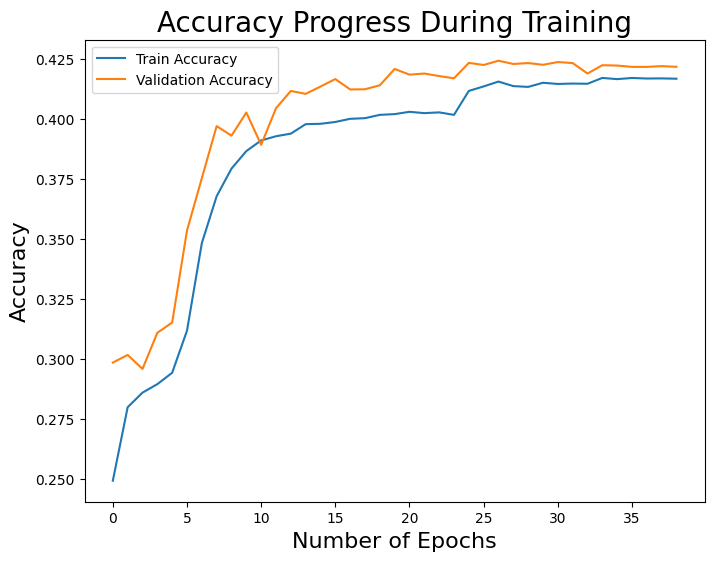

Saved Loss plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/GRU_model_v10/Loss_GRU_model_v10.svg
Saved Loss plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/GRU_model_v10/Loss_GRU_model_v10.eps
Saved Loss plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/GRU_model_v10/Loss_GRU_model_v10.png


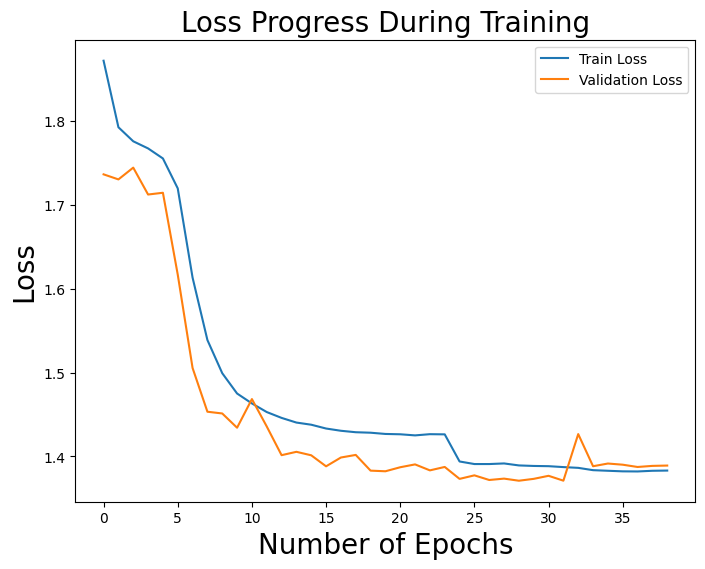

In [ ]:
base_dir = f'/content/drive/MyDrive/ColabNotebooks/RF_classification/'
model_version = f"GRU_model_{version_suffix}"
print(model_version)
load_and_plot_history(base_dir, model_version, dataset_version)


##CGDNN


In [ ]:
"""
This neural network stems originally from:

https://www.jatit.org/volumes/Vol102No3/11Vol102No3.pdf
"""

# Define the model
model_CGDNN = Sequential()
model_CGDNN.add(GRU(80, return_sequences=True, input_shape=(X.shape[1],2)))     # Adding the GRU layer with 80 cells
model_CGDNN.add(BatchNormalization())                                           # Batch normalization layer following GRU
model_CGDNN.add(ReLU())                                                         # ReLU activation layer
model_CGDNN.add(Dropout(0.2))                                                   # Dropout layer for regularization to prevent overfitting

# Transition to next block
model_CGDNN.add(Conv1D(filters=16, kernel_size=3, activation='relu'))           # Transition to CNN
model_CGDNN.add(BatchNormalization())                                           # Batch normalization layer following GRU
model_CGDNN.add(ReLU())                                                         # ReLU activation layer
model_CGDNN.add(AveragePooling1D())                                             # Global Average Pooling as a replacement for fully connected layers
model_CGDNN.add(Dropout(0.2))                                                   # Dropout layer for regularization to prevent overfitting

# Transition to next block
model_CGDNN.add(Conv1D(filters=len(signals), kernel_size=3, activation='relu'))     # Transition to CNN
model_CGDNN.add(BatchNormalization())                                               # Batch normalization layer following GRU
model_CGDNN.add(ReLU())                                                             # ReLU activation layer
model_CGDNN.add(GlobalAveragePooling1D())                                           # Global Average Pooling as a replacement for fully connected layers
model_CGDNN.add(BatchNormalization())                                               # Batch normalization layer following GRU
model_CGDNN.add(Dense(len(signals), activation='softmax'))                          # Output layer - adjust according to the number of classes in classification task


# Alligning model version to dataset version
### Uncoment those lines if you want to save the models
model_base_filepath = "/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN"
model_path = define_model_path(model_base_filepath, dataset_version, "CGDNN")


# Setting hyperparameters for training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        model_path,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=4,
        min_lr=0.00001),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)]


optimizer = keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
model_CGDNN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

No existing model file found. New model will be saved to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN/CGDNN_model_v10.tf


In [ ]:
# Model summary to verify the architecture
model_CGDNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 256, 80)           20160     
                                                                 
 batch_normalization (Batch  (None, 256, 80)           320       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 256, 80)           0         
                                                                 
 dropout (Dropout)           (None, 256, 80)           0         
                                                                 
 conv1d (Conv1D)             (None, 254, 16)           3856      
                                                                 
 batch_normalization_1 (Bat  (None, 254, 16)           64        
 chNormalization)                                       

### Initialize the training process and save history.

In [ ]:
tf.keras.backend.clear_session()
# Uncomment to load a specific model an to continue training it, else the selected new model will overwrite it
#model_GRU = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN/CGDNN_model_v6.tf")

history = model_CGDNN.fit(X_train, Y_train, batch_size=256, epochs=100, verbose=1, validation_data= (X_valid, Y_valid), callbacks=callbacks)

### Saving the histories into a folder
base_history_path = '/content/drive/MyDrive/ColabNotebooks/RF_classification/Histories'
save_training_history(history, base_history_path, dataset_version, "CGDNN", save = False)

# Uncomment this if you want to save the trained model into "model" variable
#model = model_CGDNN

Epoch 1/100
525/525 [==============================] - 24s 35ms/step - loss: 1.6998 - accuracy: 0.3423 - val_loss: 1.7548 - val_accuracy: 0.3268 - lr: 0.0010
Epoch 2/100
525/525 [==============================] - 13s 25ms/step - loss: 1.5052 - accuracy: 0.3780 - val_loss: 1.7692 - val_accuracy: 0.3217 - lr: 0.0010
Epoch 3/100
525/525 [==============================] - 17s 32ms/step - loss: 1.4754 - accuracy: 0.3843 - val_loss: 1.5087 - val_accuracy: 0.3780 - lr: 0.0010
Epoch 4/100
525/525 [==============================] - 17s 33ms/step - loss: 1.4589 - accuracy: 0.3888 - val_loss: 1.4856 - val_accuracy: 0.4086 - lr: 0.0010
Epoch 5/100
525/525 [==============================] - 13s 24ms/step - loss: 1.4482 - accuracy: 0.3921 - val_loss: 1.4980 - val_accuracy: 0.3990 - lr: 0.0010
Epoch 6/100
525/525 [==============================] - 17s 32ms/step - loss: 1.4404 - accuracy: 0.3938 - val_loss: 1.4648 - val_accuracy: 0.3918 - lr: 0.0010
Epoch 7/100
525/525 [==============================]

Show training process informations on charts. History has to be saved on your drive for this to work.

CGDNN_model_v10
/content/drive/MyDrive/ColabNotebooks/RF_classification/Histories/Dataset_v10/CGDNN_model_v10_history.pkl
Saved Accuracy plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/CGDNN_model_v10/Accuracy_CGDNN_model_v10.svg
Saved Accuracy plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/CGDNN_model_v10/Accuracy_CGDNN_model_v10.eps
Saved Accuracy plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/CGDNN_model_v10/Accuracy_CGDNN_model_v10.png


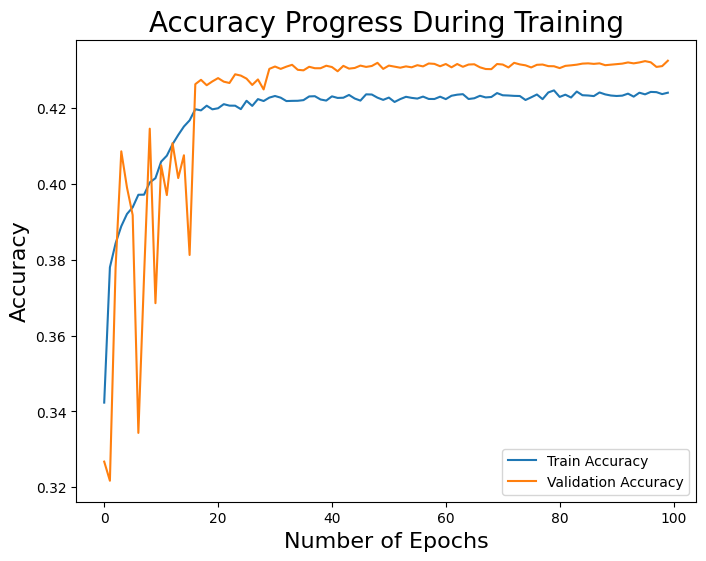

Saved Loss plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/CGDNN_model_v10/Loss_CGDNN_model_v10.svg
Saved Loss plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/CGDNN_model_v10/Loss_CGDNN_model_v10.eps
Saved Loss plot to: /content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Training_progress_figs/CGDNN_model_v10/Loss_CGDNN_model_v10.png


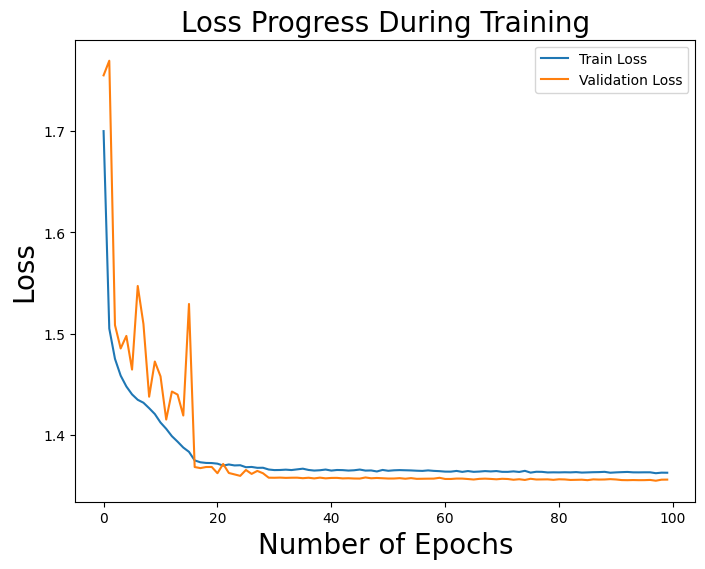

In [ ]:
base_dir = f'/content/drive/MyDrive/ColabNotebooks/RF_classification/'
model_version = f"CGDNN_model_{version_suffix}"
print(model_version)
load_and_plot_history(base_dir, model_version, dataset_version)


# Evaluation of models

## Loading the models

In [24]:
### Choose any model you want to evaluate

### V1
# Trained on AWGN only --- bad results as an example
#model_cnn_v1 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CNN/CNN_model_v1.tf")

# Trained on AWGN only
#model_gru_v1 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_v1.tf")

# Trained on AWGN only
#model_cgdnn_v1 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN/CGDNN_model_v1.tf")


### V2
# Trained on AWGN only
model_cnn_v2 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CNN/CNN_model_v2.tf")

# Trained on AWGN only
model_gru_v2 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_v2.tf")

# Trained on AWGN only
model_cgdnn_v2 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN/CGDNN_model_v2.tf")


### V4
# Trained on AWGN + Phase offset + amplitude I/Q imbalance
#model_cnn_v4 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CNN/CNN_model_v4.tf")

# Trained on AWGN + Phase offset + amplitude I/Q imbalance
#model_gru_v4 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_v4.tf")

# Trained on AWGN + Phase offset + amplitude I/Q imbalance
#model_cgdnn_v4 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN/CGDNN_model_v4.tf")

### V5

# Trained on AWGN + Phase offset + amplitude I/Q imbalance + Rician Channel
#model_cnn_v5 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CNN/CNN_model_v5.tf")

# Trained on AWGN + Phase offset + amplitude I/Q imbalance + Rician Channel
#model_gru_v5 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_v5.tf")

# Trained on AWGN + Phase offset + amplitude I/Q imbalance + Rician Channel
#model_cgdnn_v5 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN/CGDNN_model_v5.tf")

### V6


# Trained on AWGN + Phase offset + amplitude I/Q imbalance + Rayleigh channel
#model_cnn_v6 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CNN/CNN_model_v6.tf")

# Trained on AWGN + Phase offset + amplitude I/Q imbalance + Rayleigh channel
#model_gru_v6 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_v6.tf")

# Trained on AWGN + Phase offset + amplitude I/Q imbalance + Rician channel
#model_cgdnn_v6 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN/CGDNN_model_v6.tf")


### V7
# v7 - AWGN + phase offset dataset + amplitude I/Q imbalance dataset -- Trimmed method from Maršálek
#model_cnn_v7 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CNN/CNN_model_v7.tf")

# v7 - AWGN + phase offset dataset + amplitude I/Q imbalance dataset -- Trimmed method from Maršálek
#model_gru_v7 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_v7.tf")

# v7 - AWGN + phase offset dataset + amplitude I/Q imbalance dataset -- Trimmed method from Maršálek
#model_cgdnn_v7 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN/CGDNN_model_v7.tf")


### V9

# Trained on AWGN + Phase offset + amplitude I/Q imbalance --- with mixed signals 7 classes
#model_cnn_v9 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CNN/CNN_model_v9.tf")

# Trained on AWGN + Phase offset + amplitude I/Q imbalance --- with mixed signals 7 classes
#model_gru_v9 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_v9.tf")

# Trained on AWGN + Phase offset + amplitude I/Q imbalance --- with mixed signals 7 classes
#model_cgdnn_v9 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN/CGDNN_model_v9.tf")


### V10

# Trained on AWGN + Phase offset + amplitude I/Q imbalance --- with mixed signals 8 classes
#model_cnn_v10 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CNN/CNN_model_v10.tf")

# Trained on AWGN + Phase offset + amplitude I/Q imbalance --- with mixed signals 8 classes
#model_gru_v10 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_v10.tf")

# Trained on AWGN + Phase offset + amplitude I/Q imbalance --- with mixed signals 8 classes
#model_cgdnn_v10 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN/CGDNN_model_v10.tf")


### V11

# Trained on AWGN + Phase offset + amplitude I/Q imbalance --- WLAN TASK
#model_cnn_v11 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CNN/CNN_model_v11.tf")

# Trained on AWGN + Phase offset + amplitude I/Q imbalance --- WLAN TASK
#model_gru_v11 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_v11.tf")

# Trained on AWGN + Phase offset + amplitude I/Q imbalance --- WLAN TASK
#model_cgdnn_v11 = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN/CGDNN_model_v11.tf")



### V modulations

# Dataset_modulations
#model_cnn_modulations = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CNN/CNN_model_modulations.tf")

# Dataset_modulations
#model_gru_modulations = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/GRU/GRU_model_modulations.tf")

# Dataset_modulations
#model_cgdnn_modulations = keras.models.load_model("/content/drive/MyDrive/ColabNotebooks/RF_classification/Models/CGDNN/CGDNN_model_modulations.tf")


### Add the chosen models to this list
models = [model_cnn_v2, model_gru_v2, model_cgdnn_v2]
model_names = ['CNN', 'GRU', 'CGDNN']

### Make an evaluation
test_loss, test_acc = model_cnn_v2.evaluate(X_test, Y_test)
### Print evaluation results
print("Test accuracy", test_acc)
print("Test loss", test_loss)



450/450 [==============================] - 3s 5ms/step - loss: 0.4145 - accuracy: 0.8149
Test accuracy 0.8149305582046509
Test loss 0.4144524037837982


## Display SNR accuracy


SNR -10dB:
28/28 - 0s - loss: 1.3273 - accuracy: 0.3490 - 343ms/epoch - 12ms/step

SNR -8dB:
28/28 - 0s - loss: 1.2749 - accuracy: 0.3940 - 190ms/epoch - 7ms/step

SNR -6dB:
30/30 - 0s - loss: 1.1952 - accuracy: 0.4429 - 192ms/epoch - 6ms/step

SNR -4dB:
28/28 - 0s - loss: 1.0800 - accuracy: 0.5341 - 221ms/epoch - 8ms/step

SNR -2dB:
29/29 - 0s - loss: 0.8406 - accuracy: 0.6469 - 168ms/epoch - 6ms/step

SNR 0dB:
28/28 - 0s - loss: 0.5721 - accuracy: 0.7738 - 153ms/epoch - 5ms/step

SNR 2dB:
28/28 - 0s - loss: 0.2787 - accuracy: 0.9011 - 159ms/epoch - 6ms/step

SNR 4dB:
29/29 - 0s - loss: 0.0710 - accuracy: 0.9846 - 162ms/epoch - 6ms/step

SNR 6dB:
29/29 - 0s - loss: 0.0299 - accuracy: 0.9912 - 160ms/epoch - 6ms/step

SNR 8dB:
29/29 - 0s - loss: 0.0119 - accuracy: 0.9956 - 161ms/epoch - 6ms/step

SNR 10dB:
28/28 - 0s - loss: 0.0044 - accuracy: 0.9989 - 140ms/epoch - 5ms/step

SNR 12dB:
29/29 - 0s - loss: 0.0016 - accuracy: 1.0000 - 148ms/epoch - 5ms/step

SNR 14dB:
30/30 - 0s - loss: 0

Saved SNR accuracy plot for Dataset_v2 to /content/drive/MyDrive/ColabNotebooks/RF_classification/SNR_accuracies


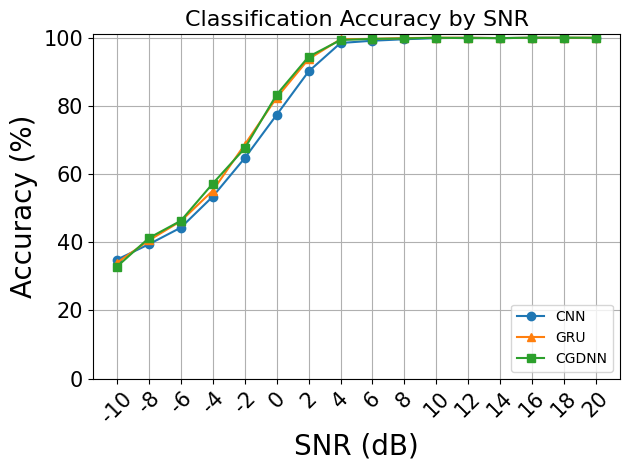

In [25]:
SNR_accuracy(SNR, model_names, num_bins, test_idx, lbl_SNR, X_test, Y_test, models, dataset_version, save = False)

## Plot Confusion Matrices

450/450 [==============================] - 3s 5ms/step


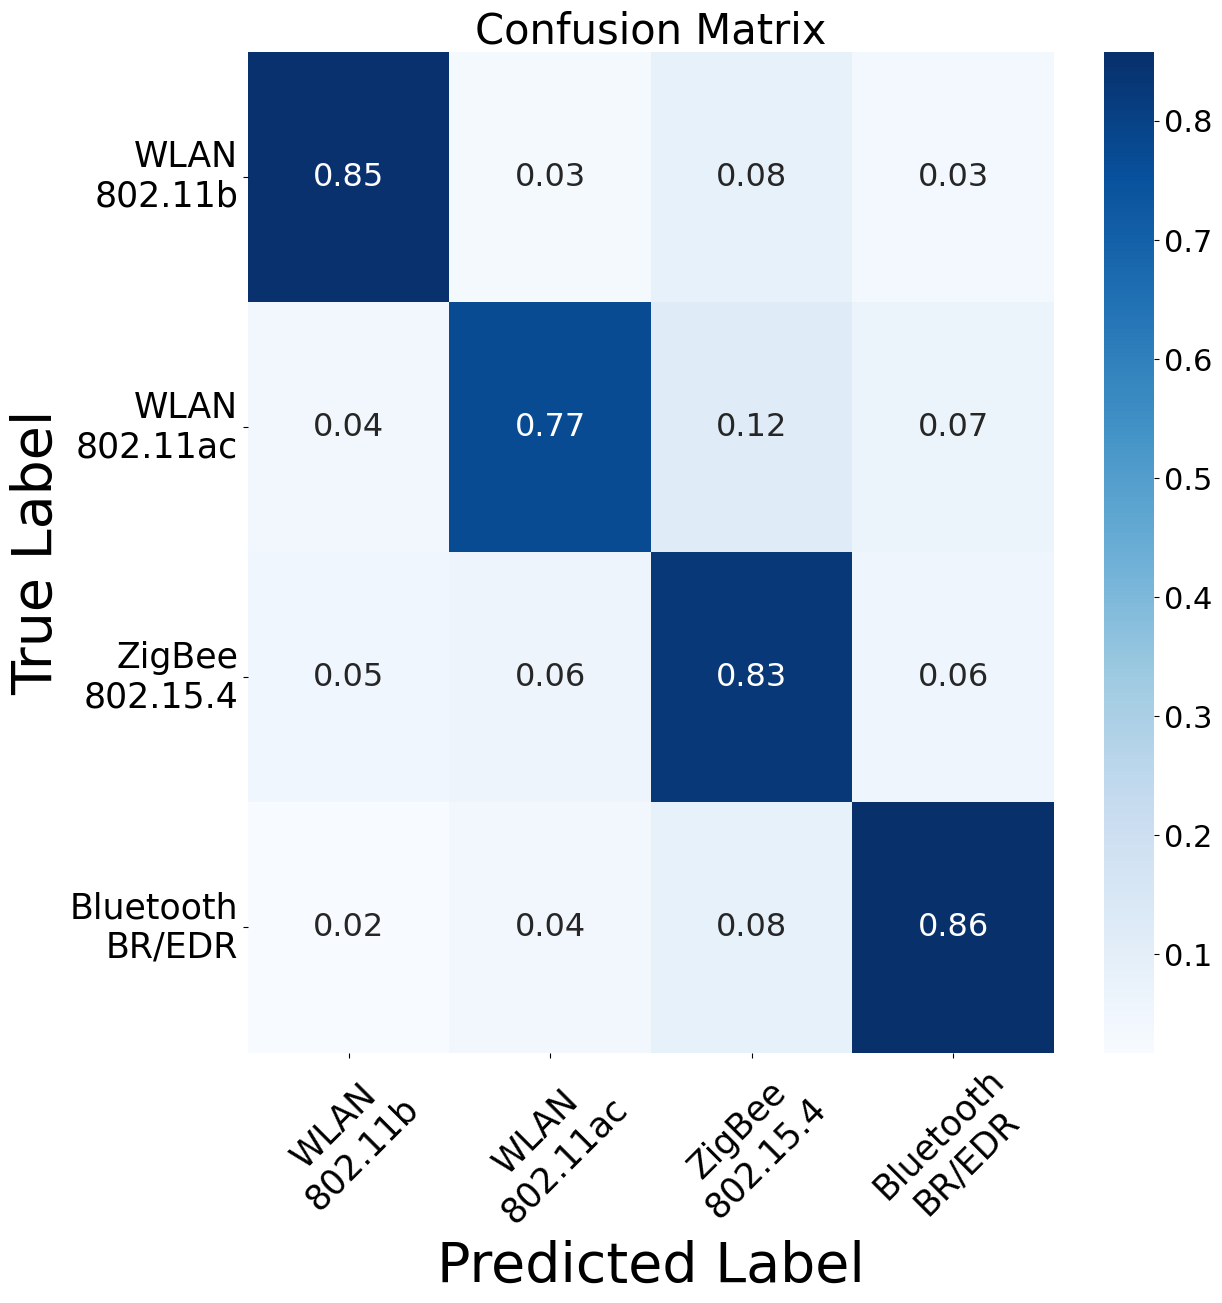

In [ ]:
# Please specify the path where you want to save CMs
CM_path = '/content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Confusion_Matrix/'

# Choose models that have been loaded
model = model_cgdnn_v2
model_name = 'model_cgdnn_v2'

# set save to False if you dont want to save

CM_full_path = create_directory_for_model(CM_path, model_name, dataset_version, save = False)
All_SNR_show_confusion_matrix(X_test, model, CM_full_path, save=False)

450/450 [==============================] - 2s 5ms/step


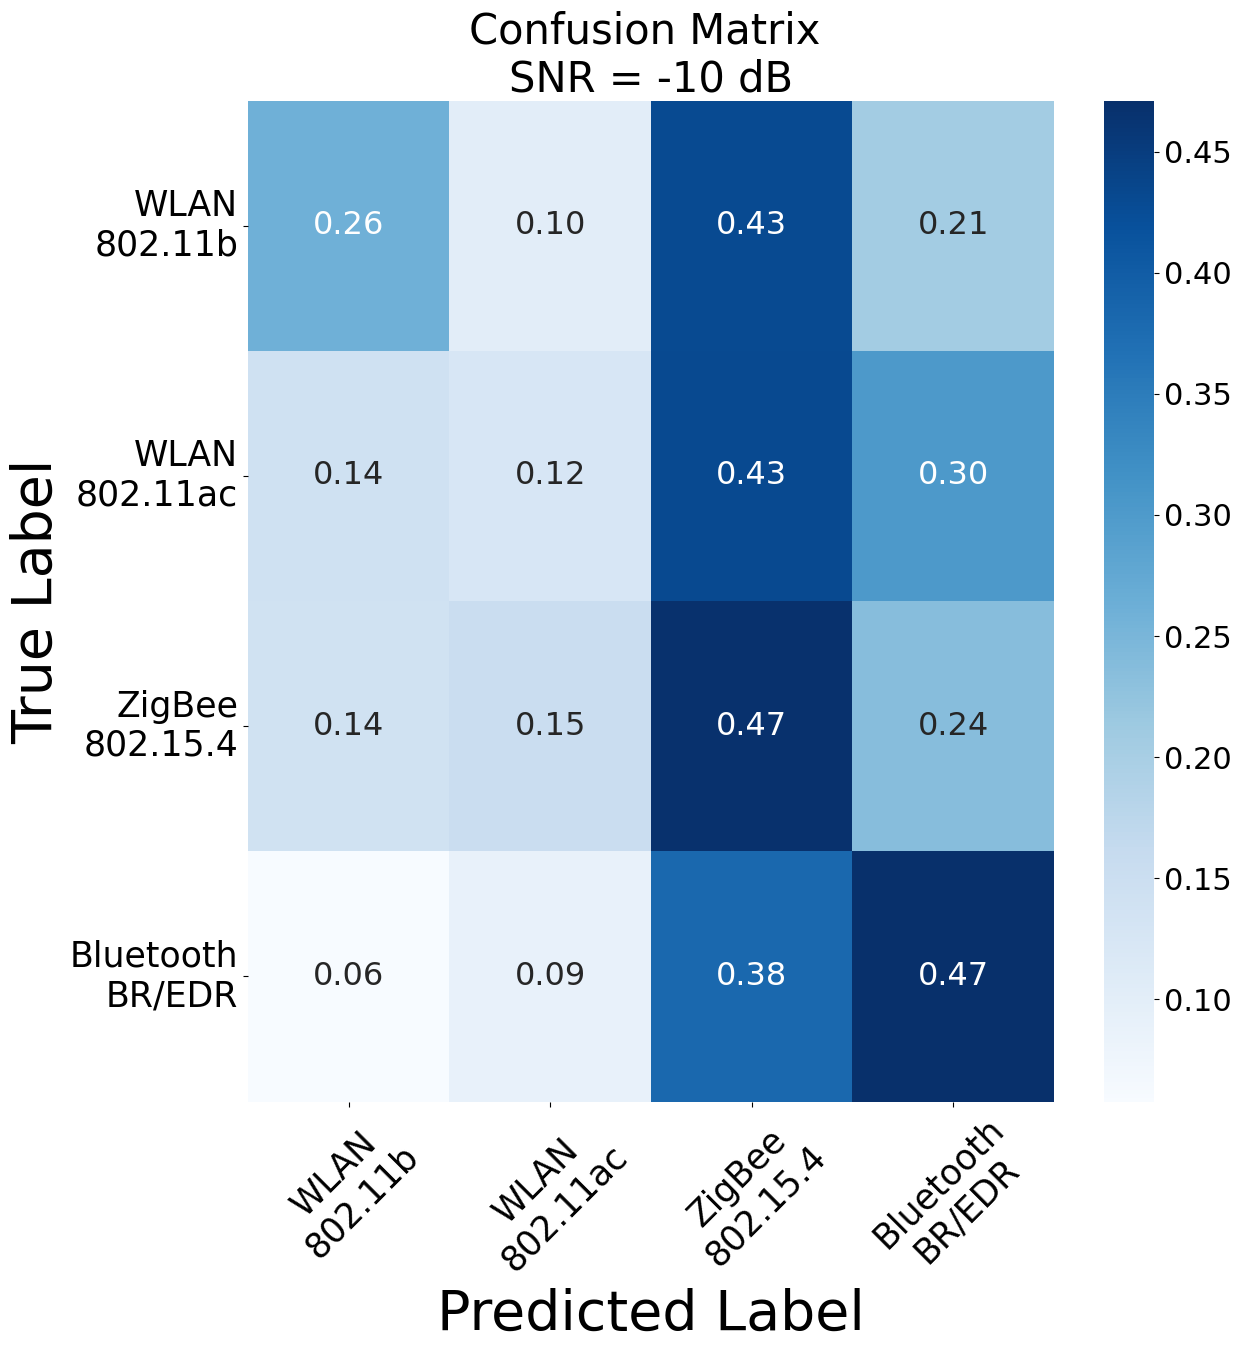

450/450 [==============================] - 2s 5ms/step


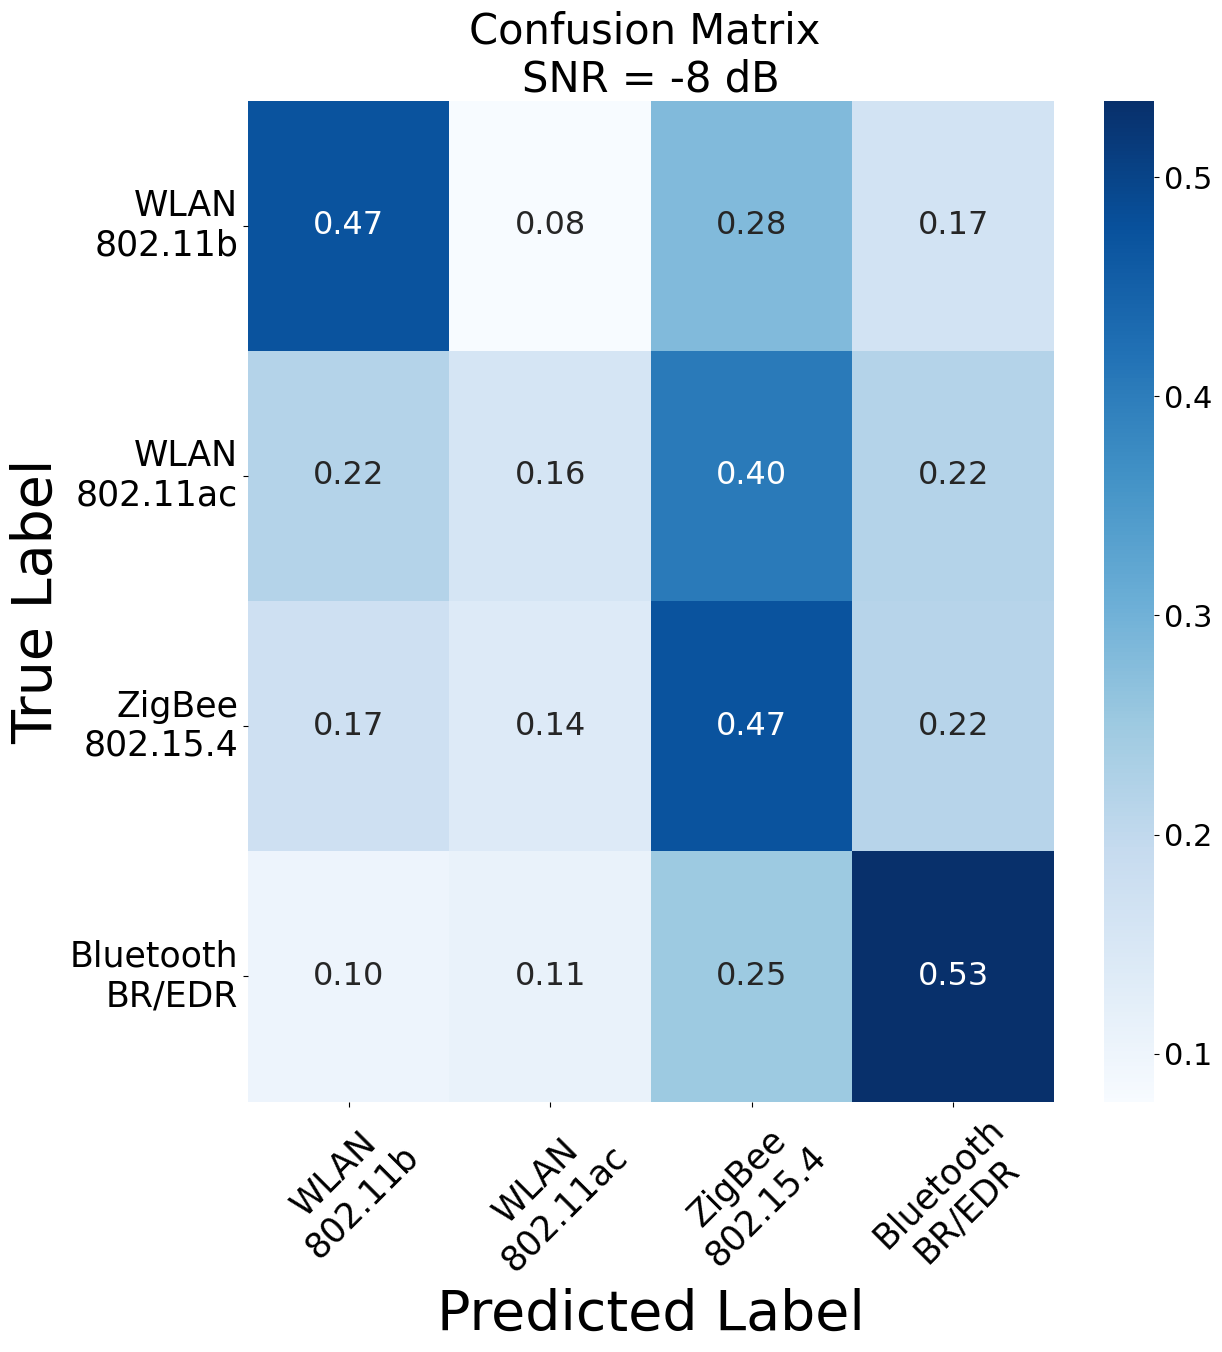

450/450 [==============================] - 2s 5ms/step


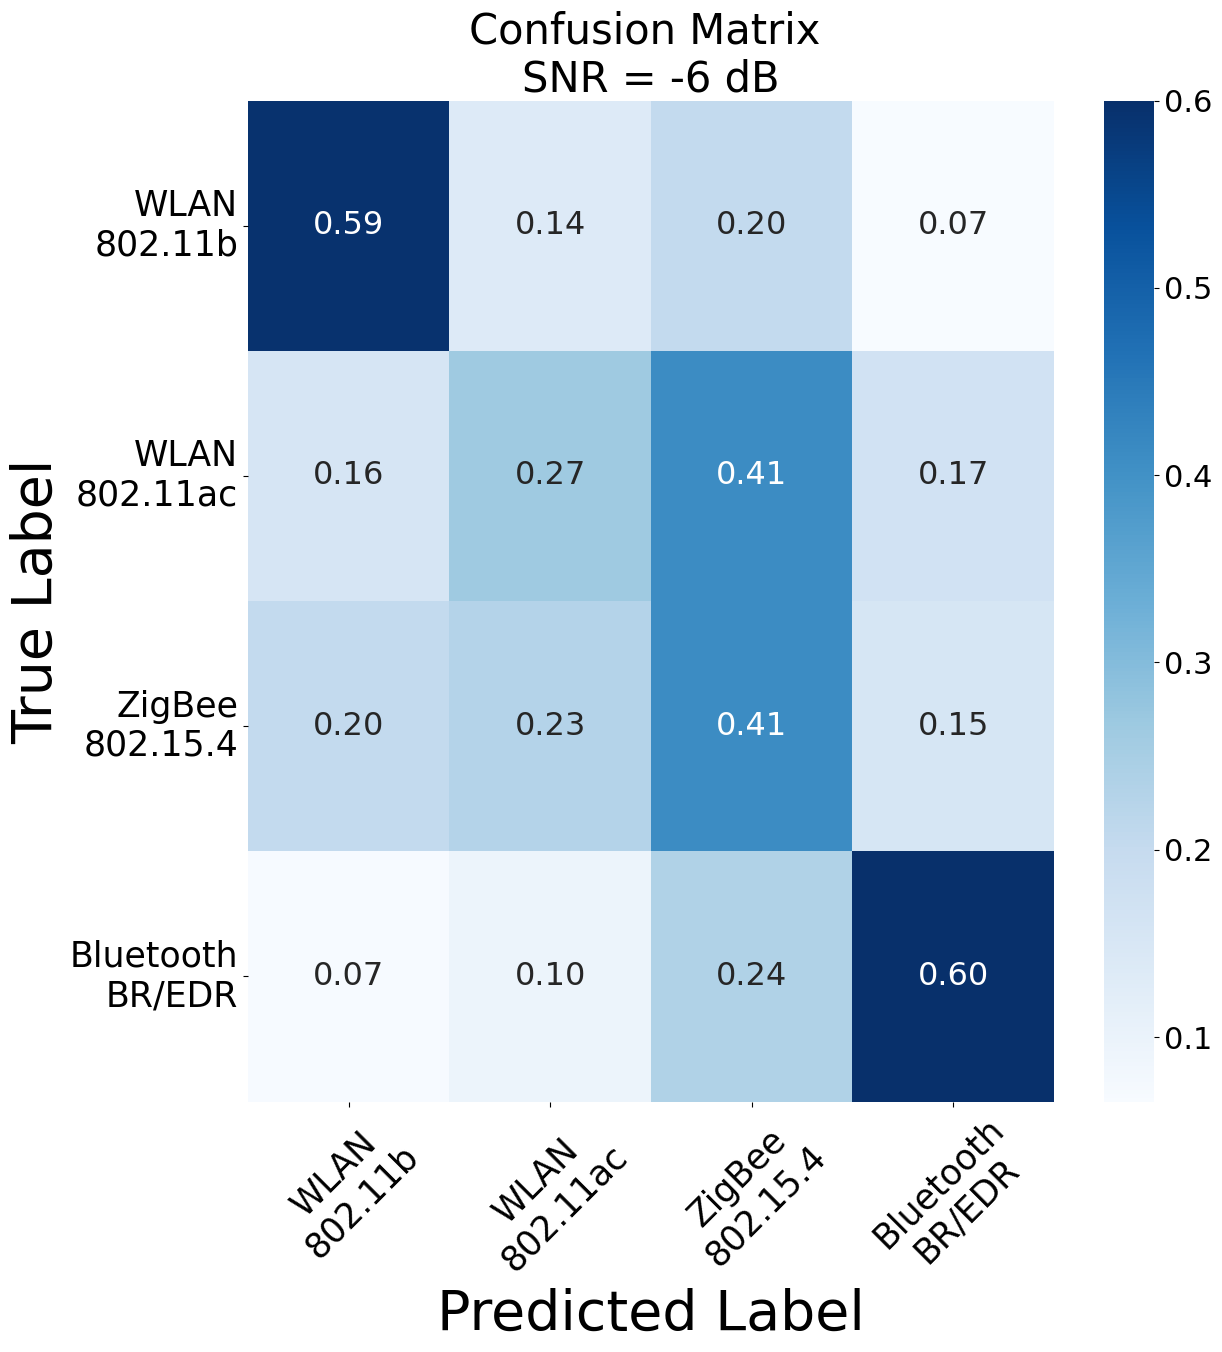

450/450 [==============================] - 2s 5ms/step


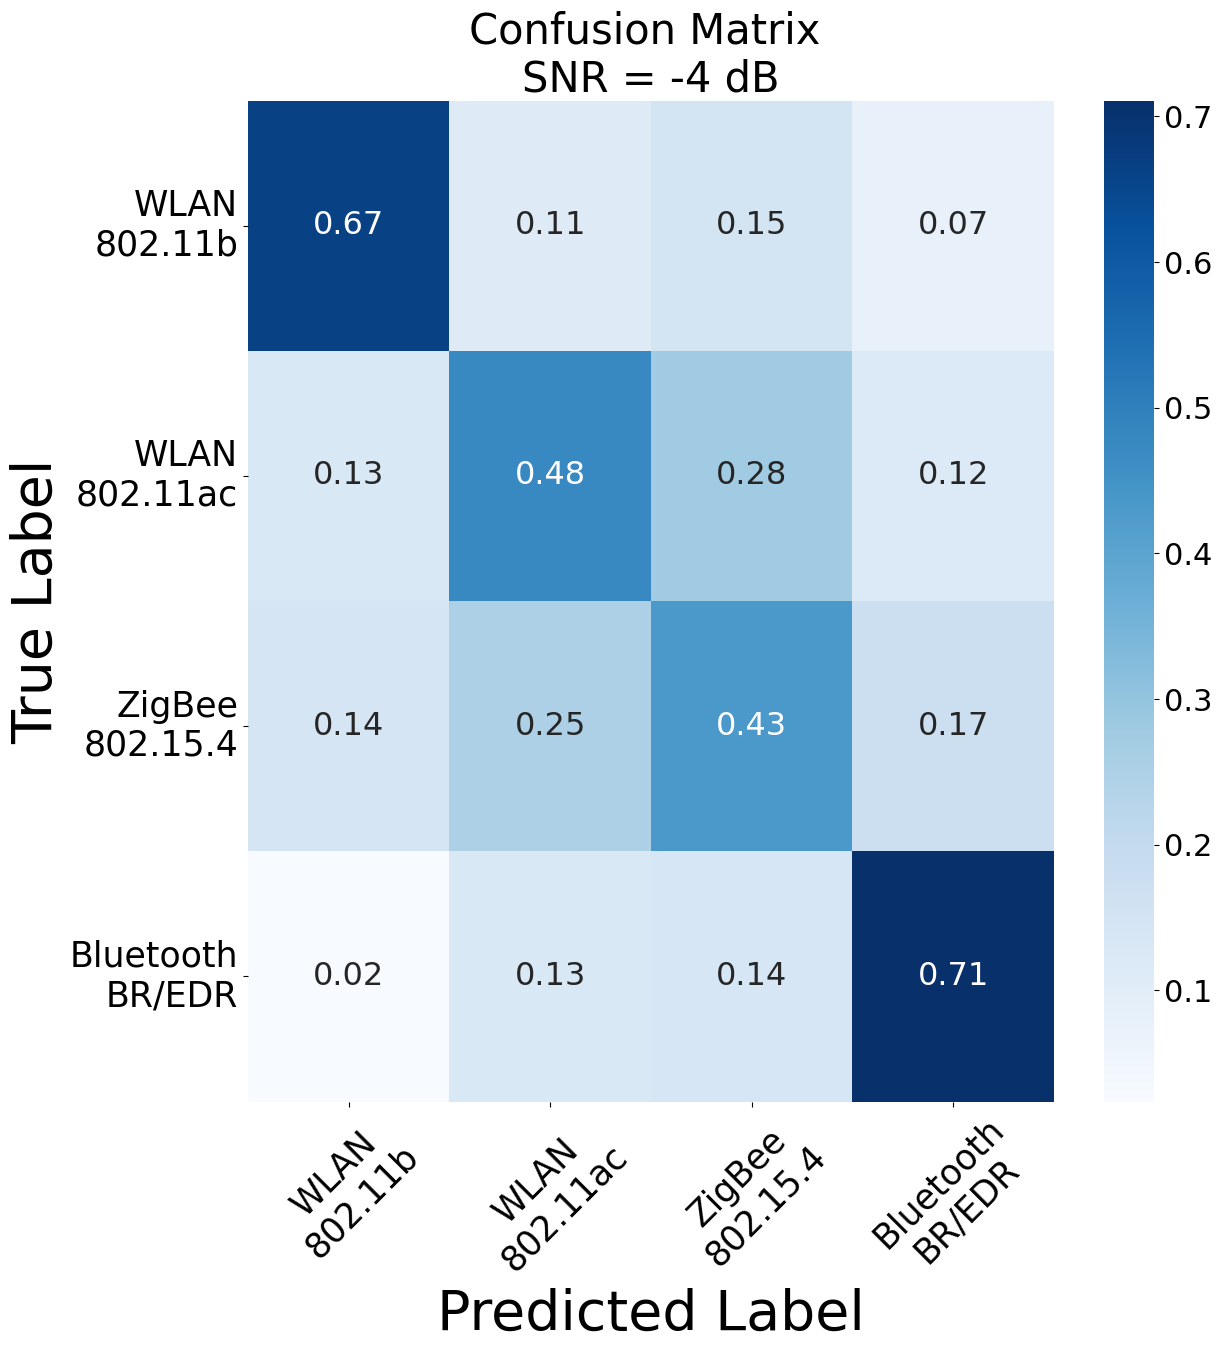

450/450 [==============================] - 2s 5ms/step


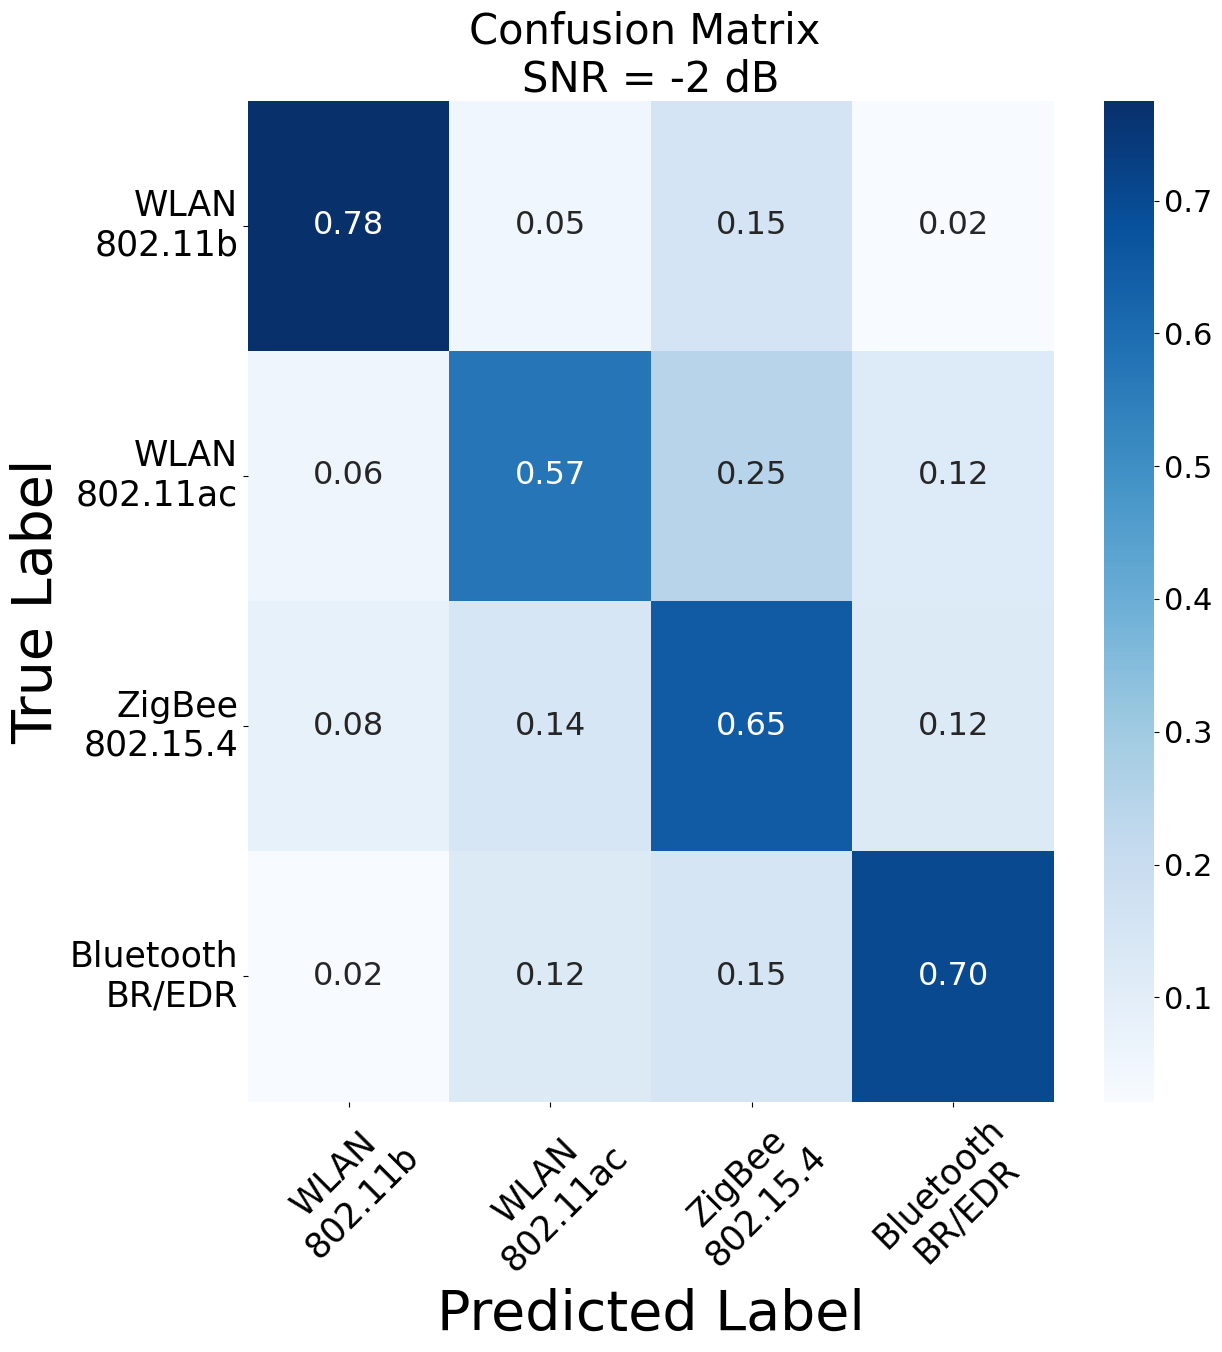

450/450 [==============================] - 2s 5ms/step


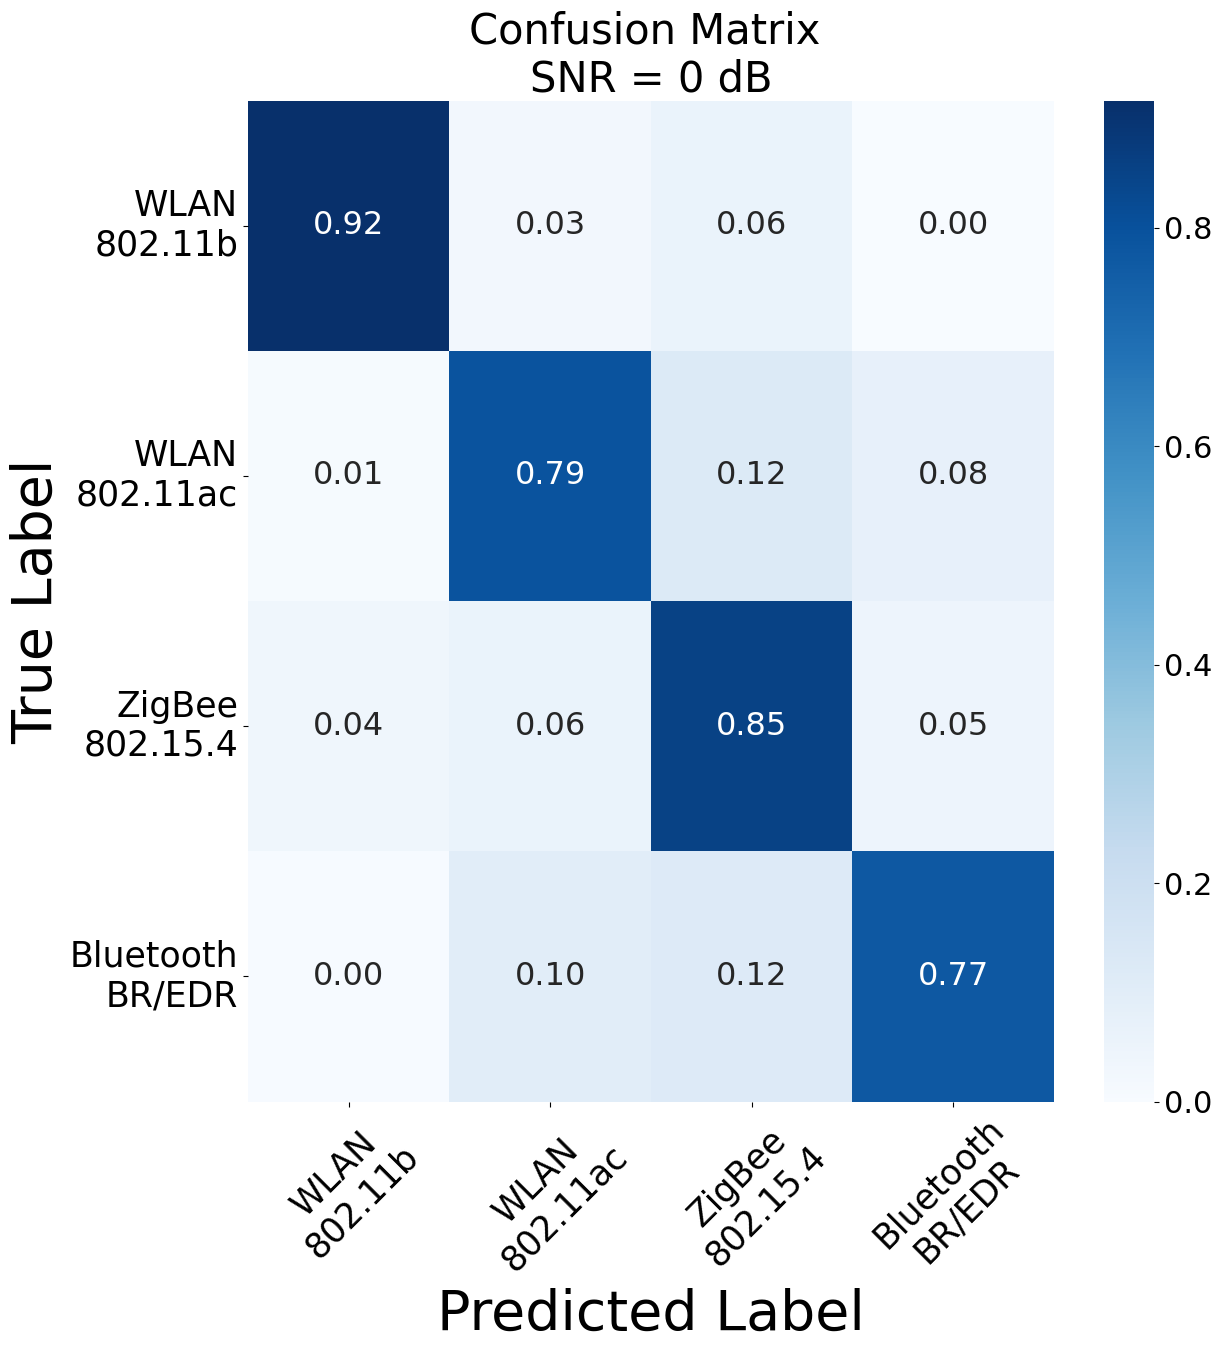

450/450 [==============================] - 2s 5ms/step


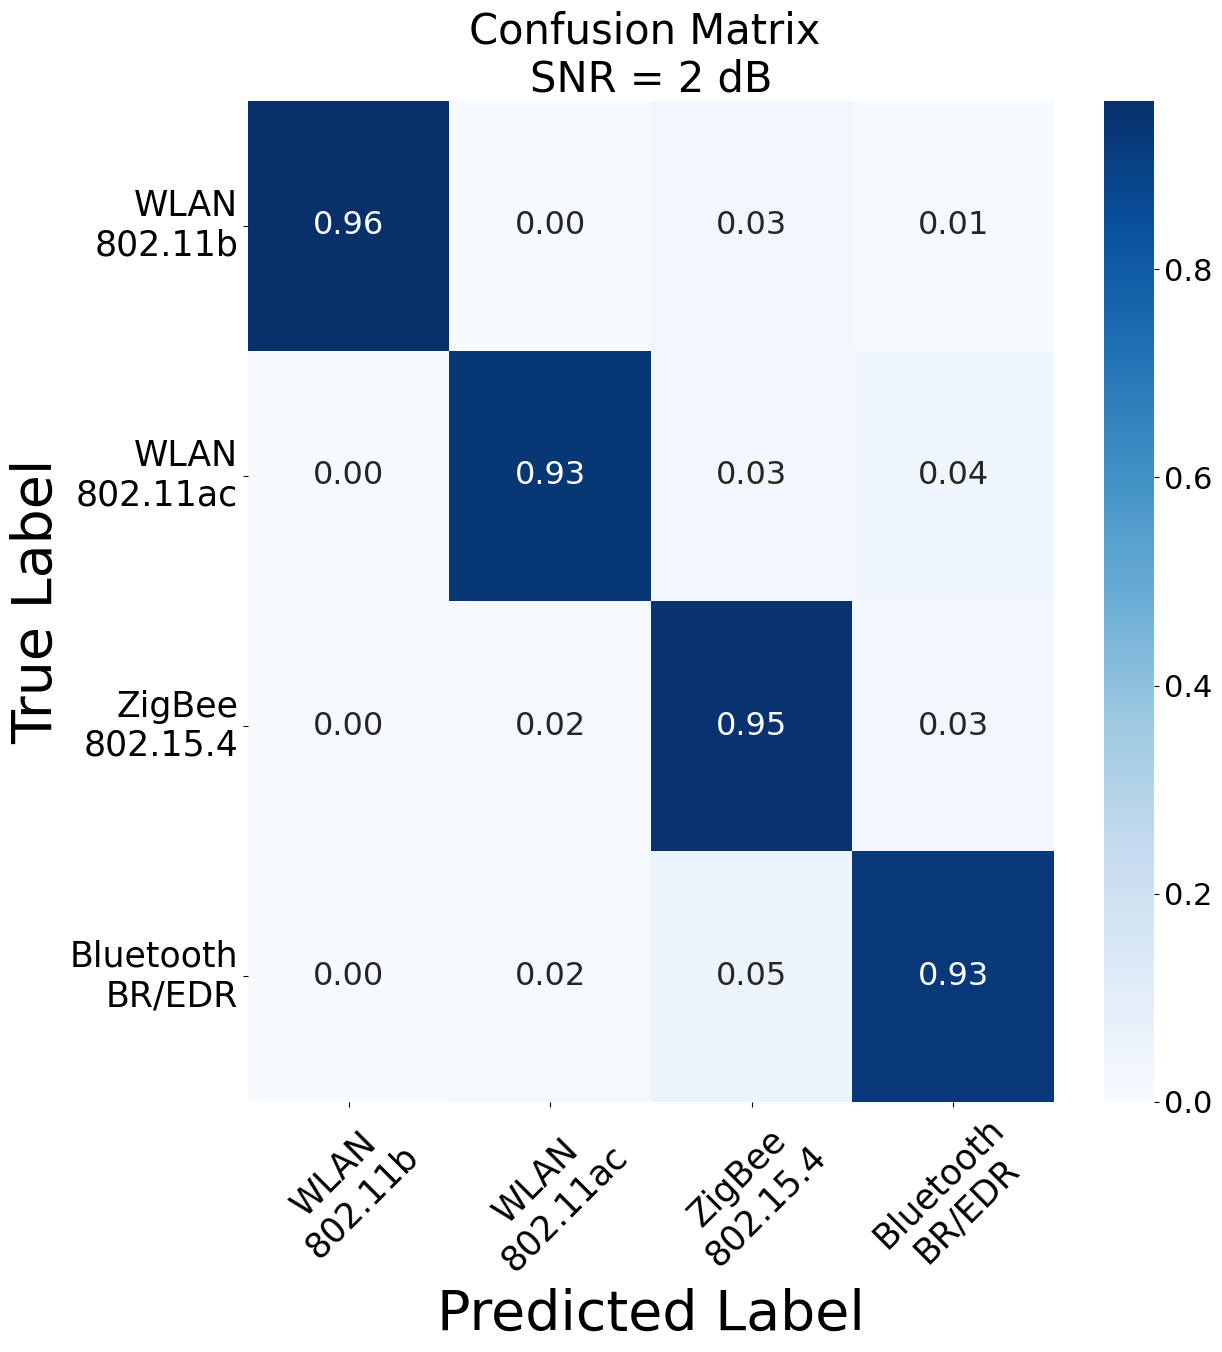

450/450 [==============================] - 2s 5ms/step


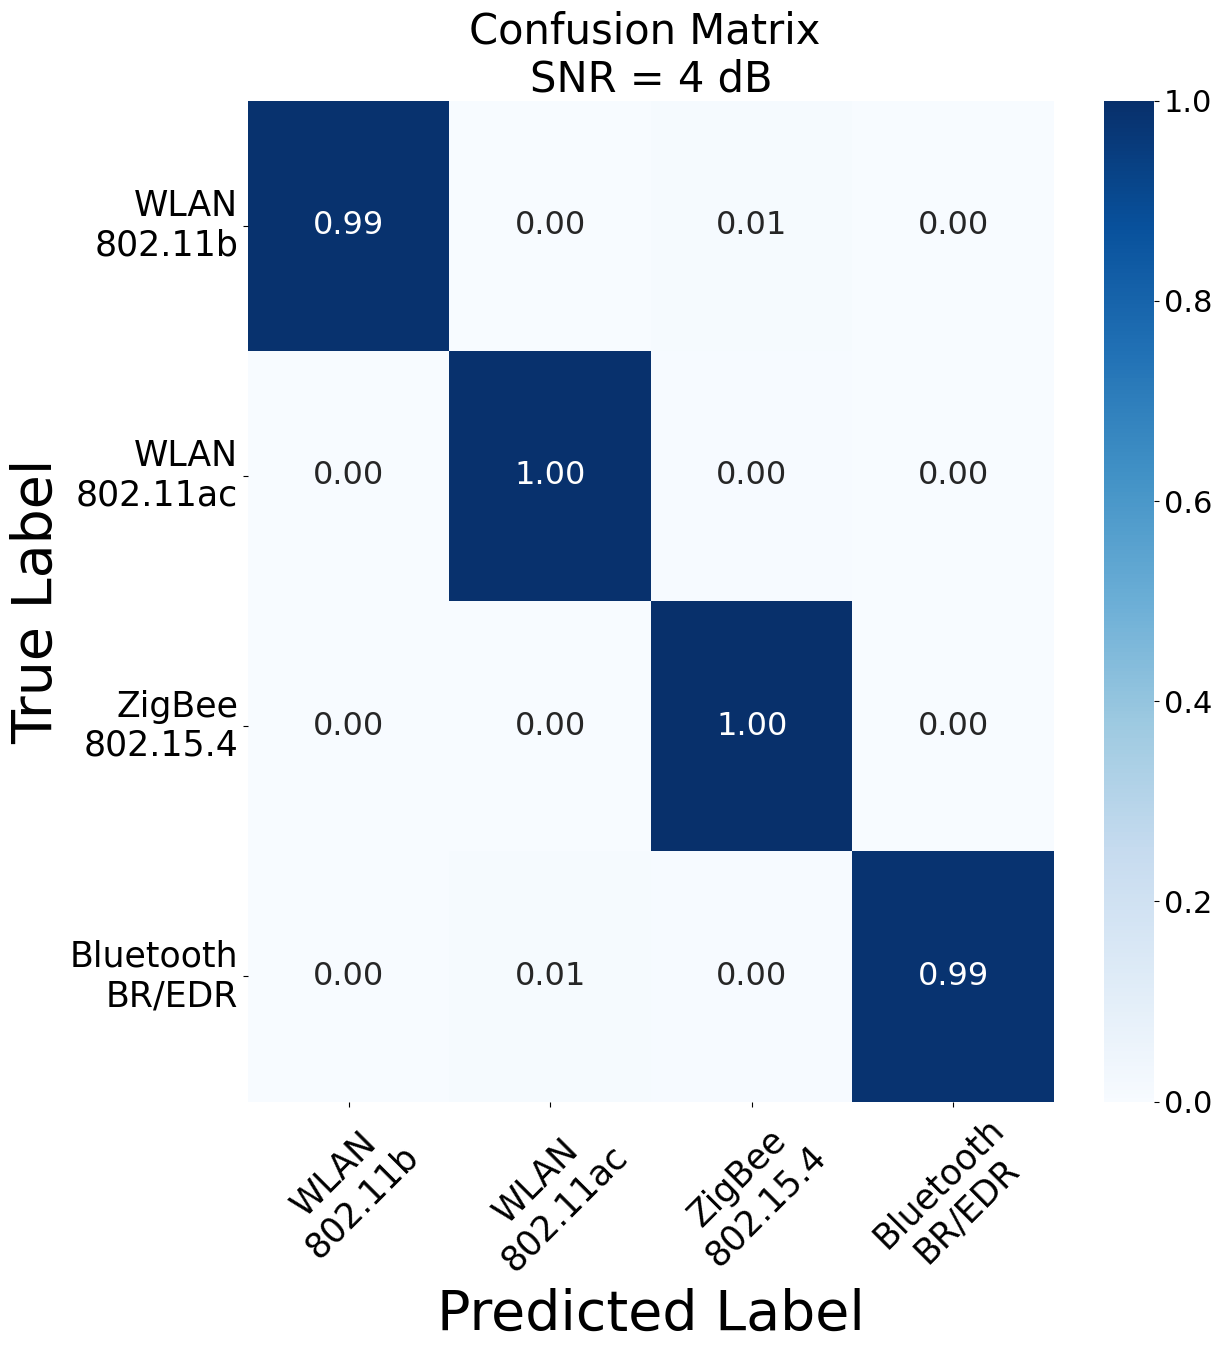

450/450 [==============================] - 2s 5ms/step


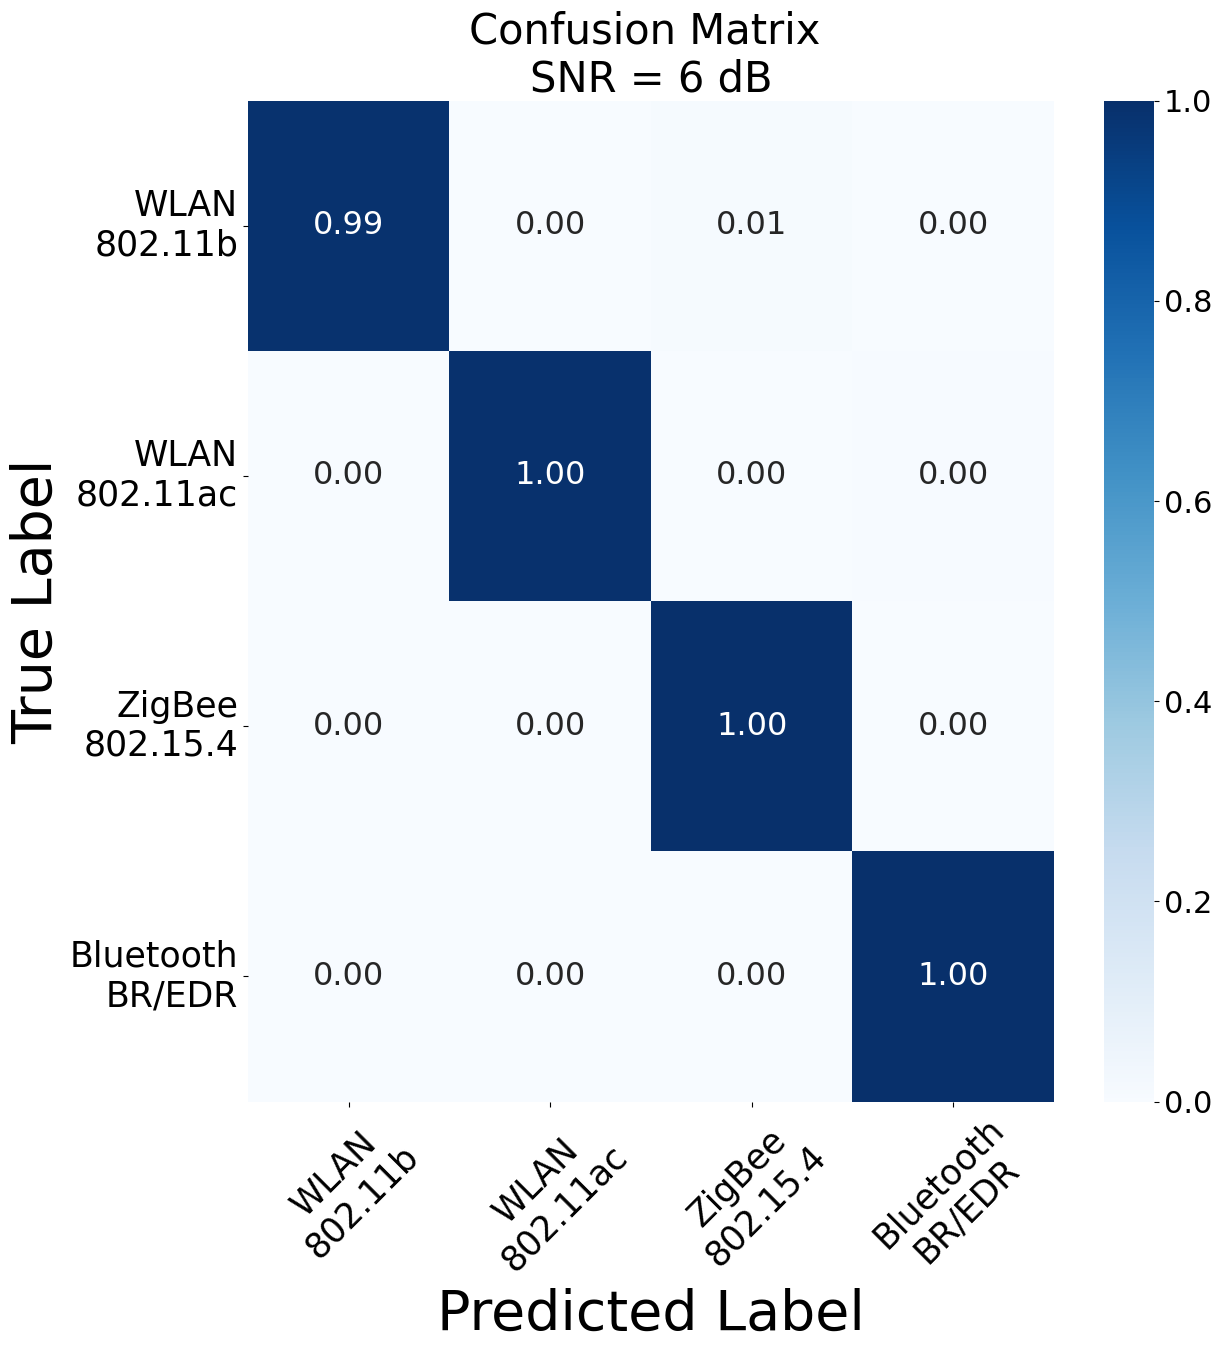

450/450 [==============================] - 2s 5ms/step


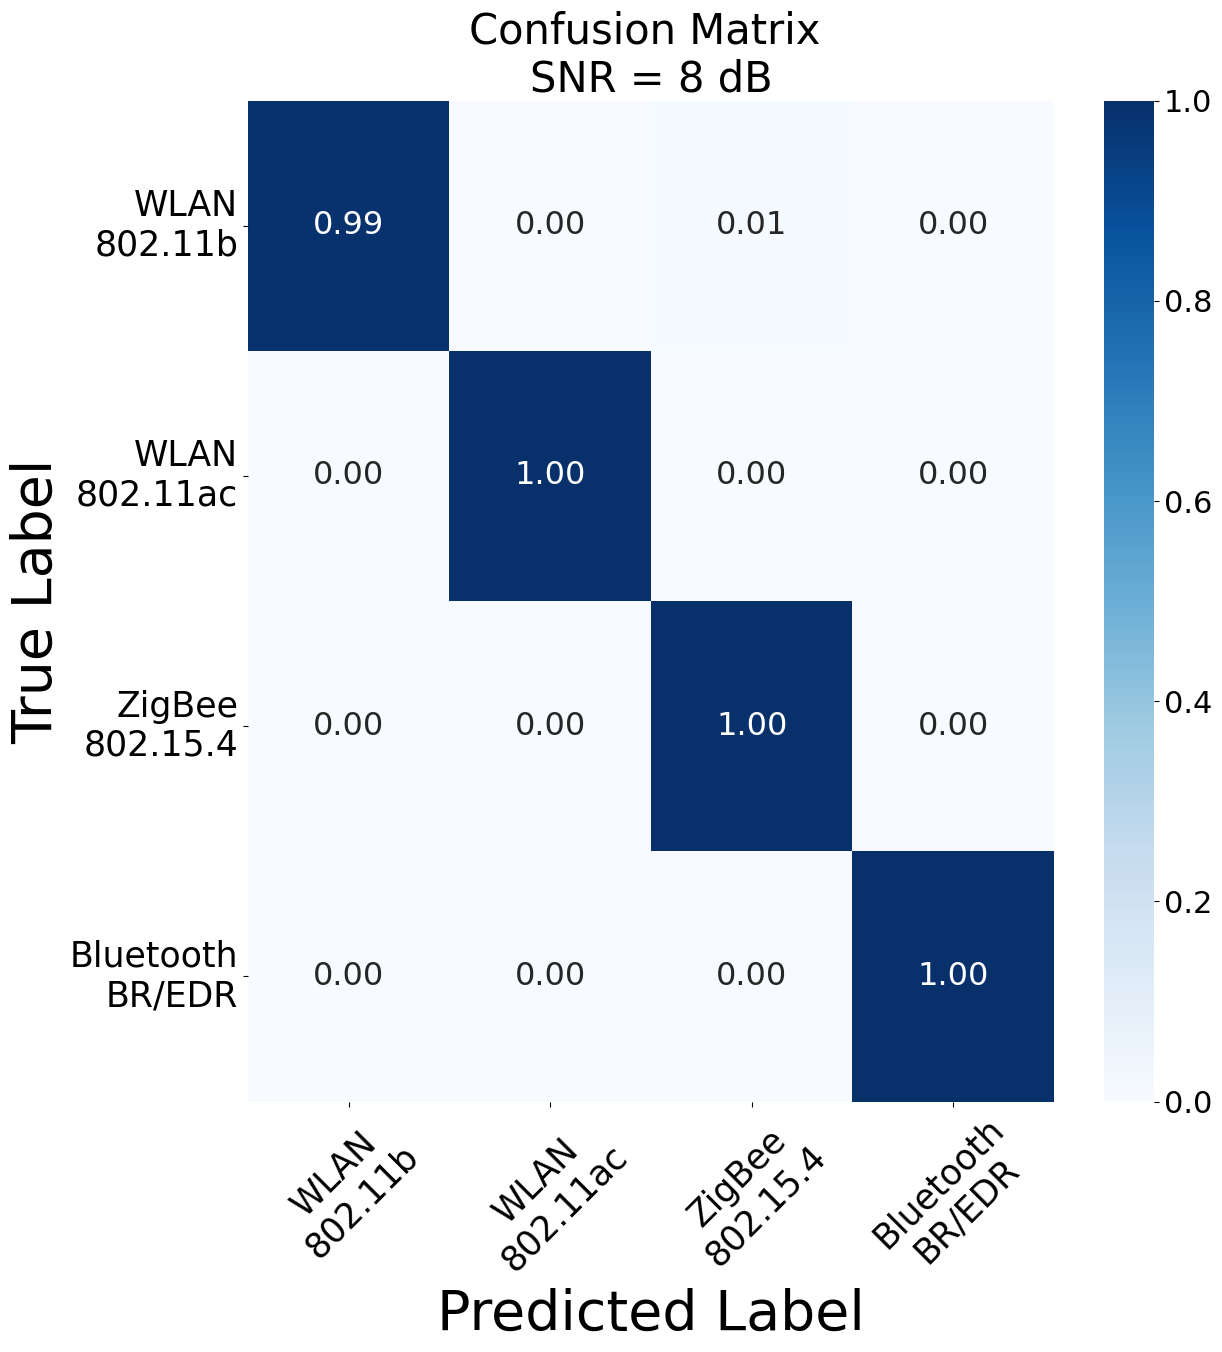

450/450 [==============================] - 2s 5ms/step


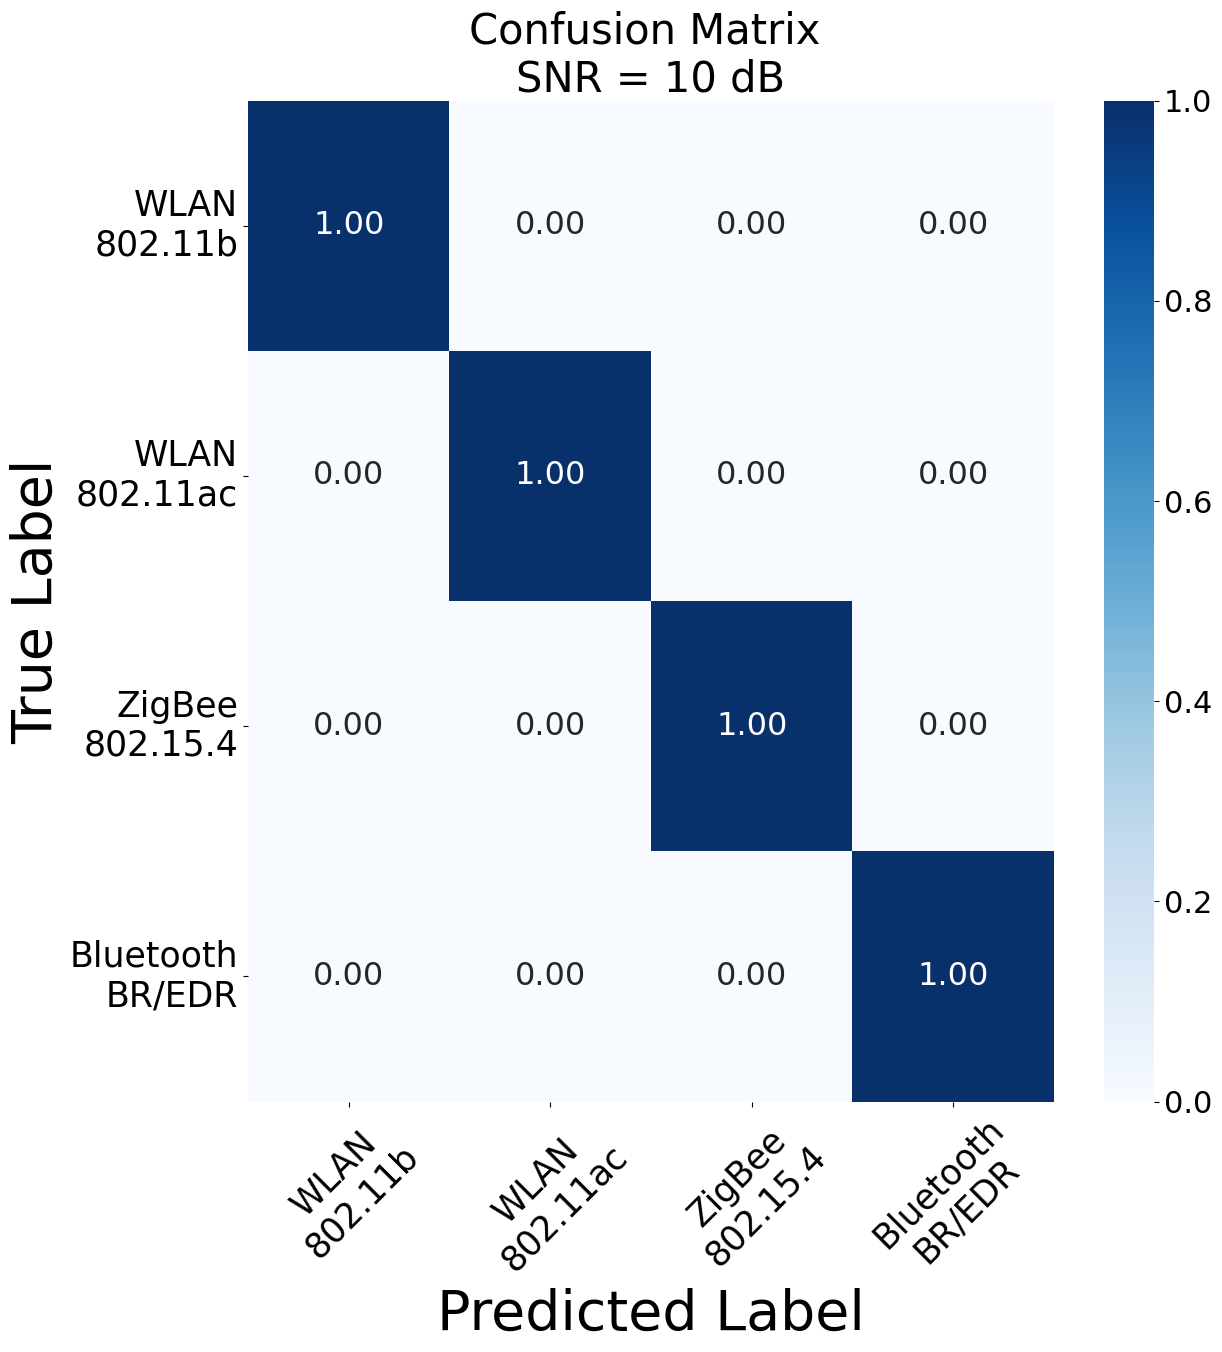

450/450 [==============================] - 2s 5ms/step


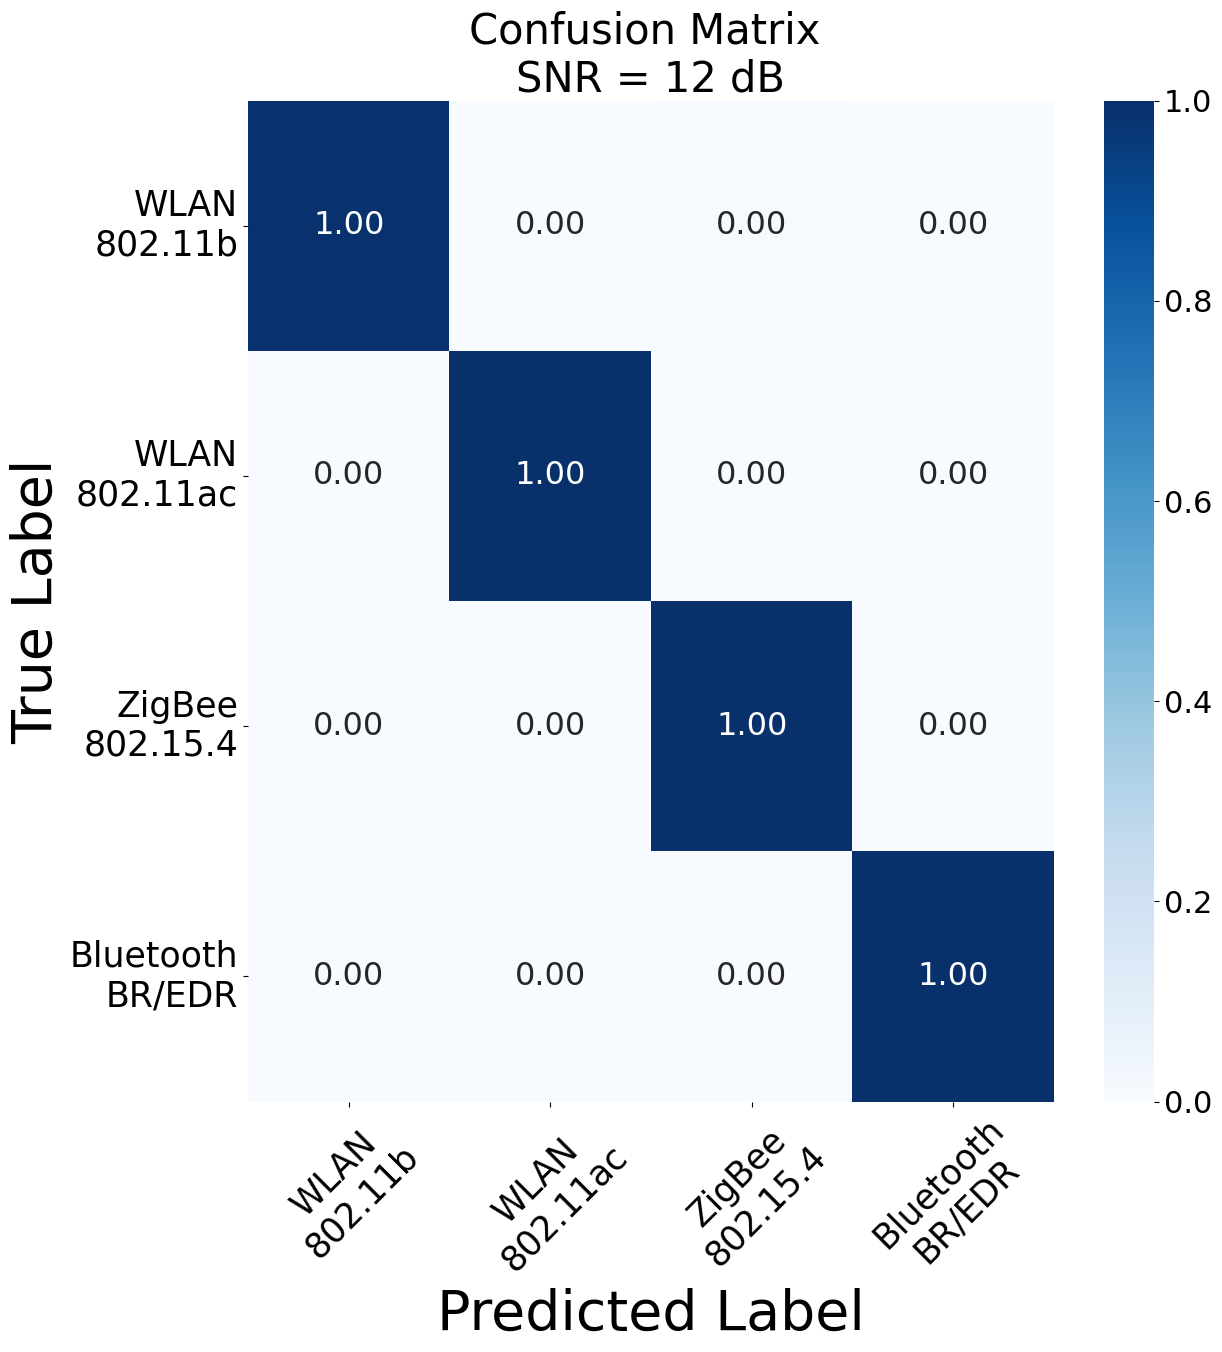

450/450 [==============================] - 2s 5ms/step


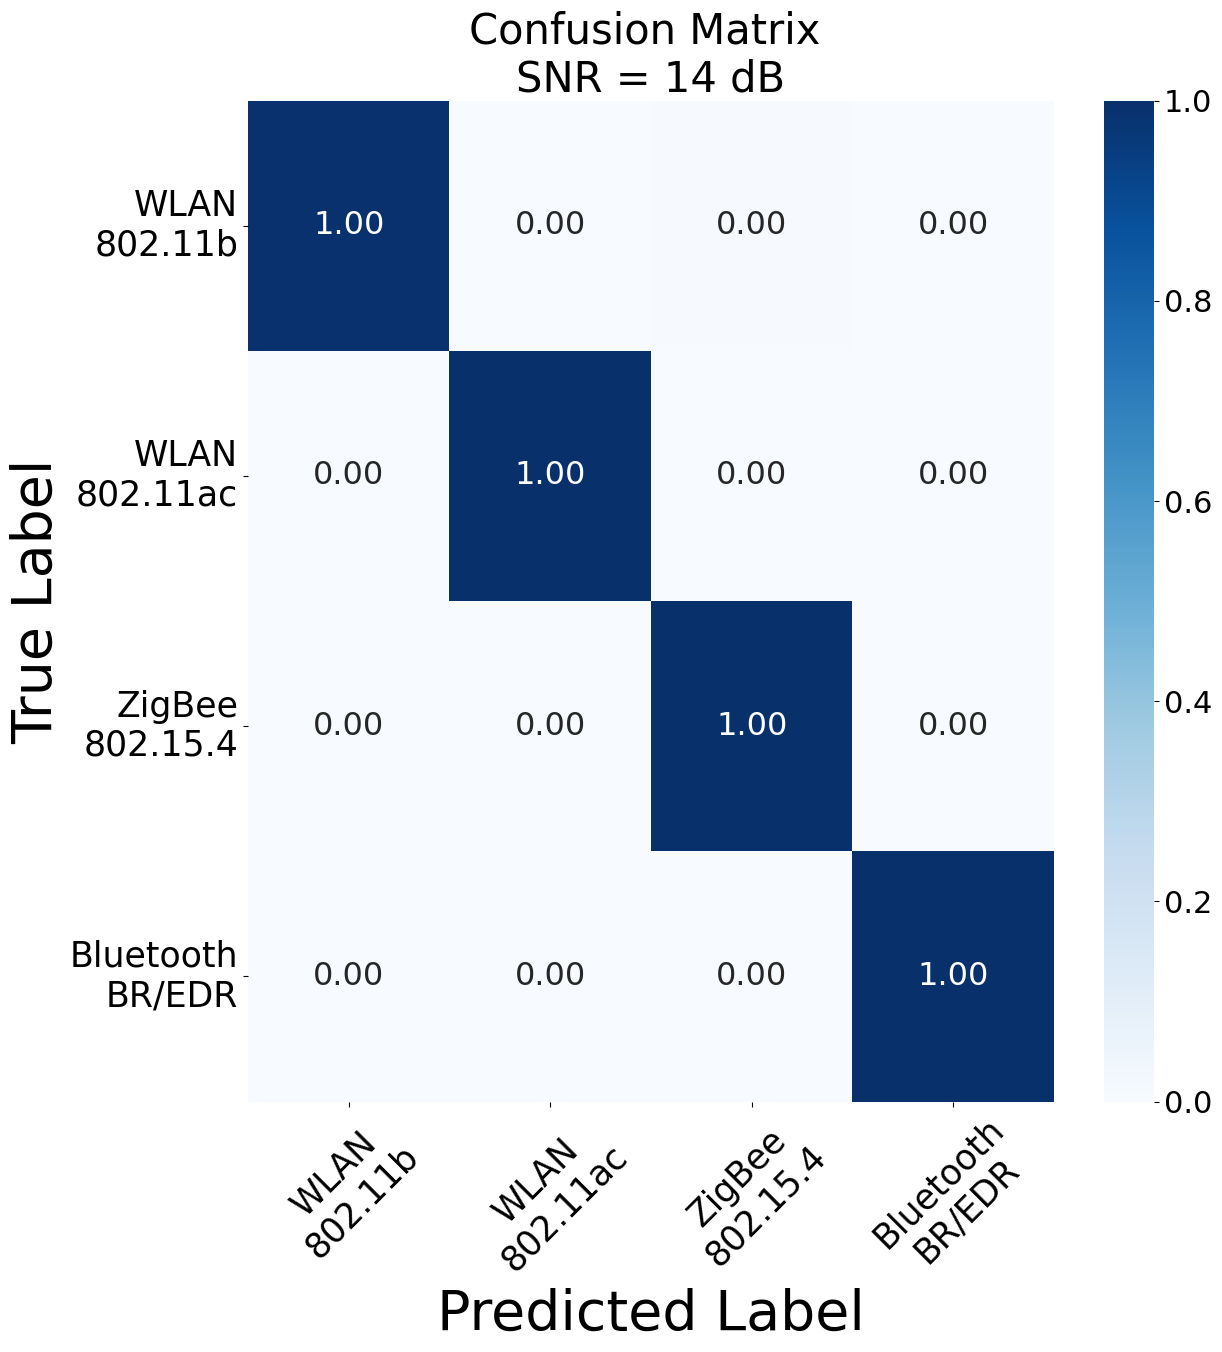

450/450 [==============================] - 2s 5ms/step


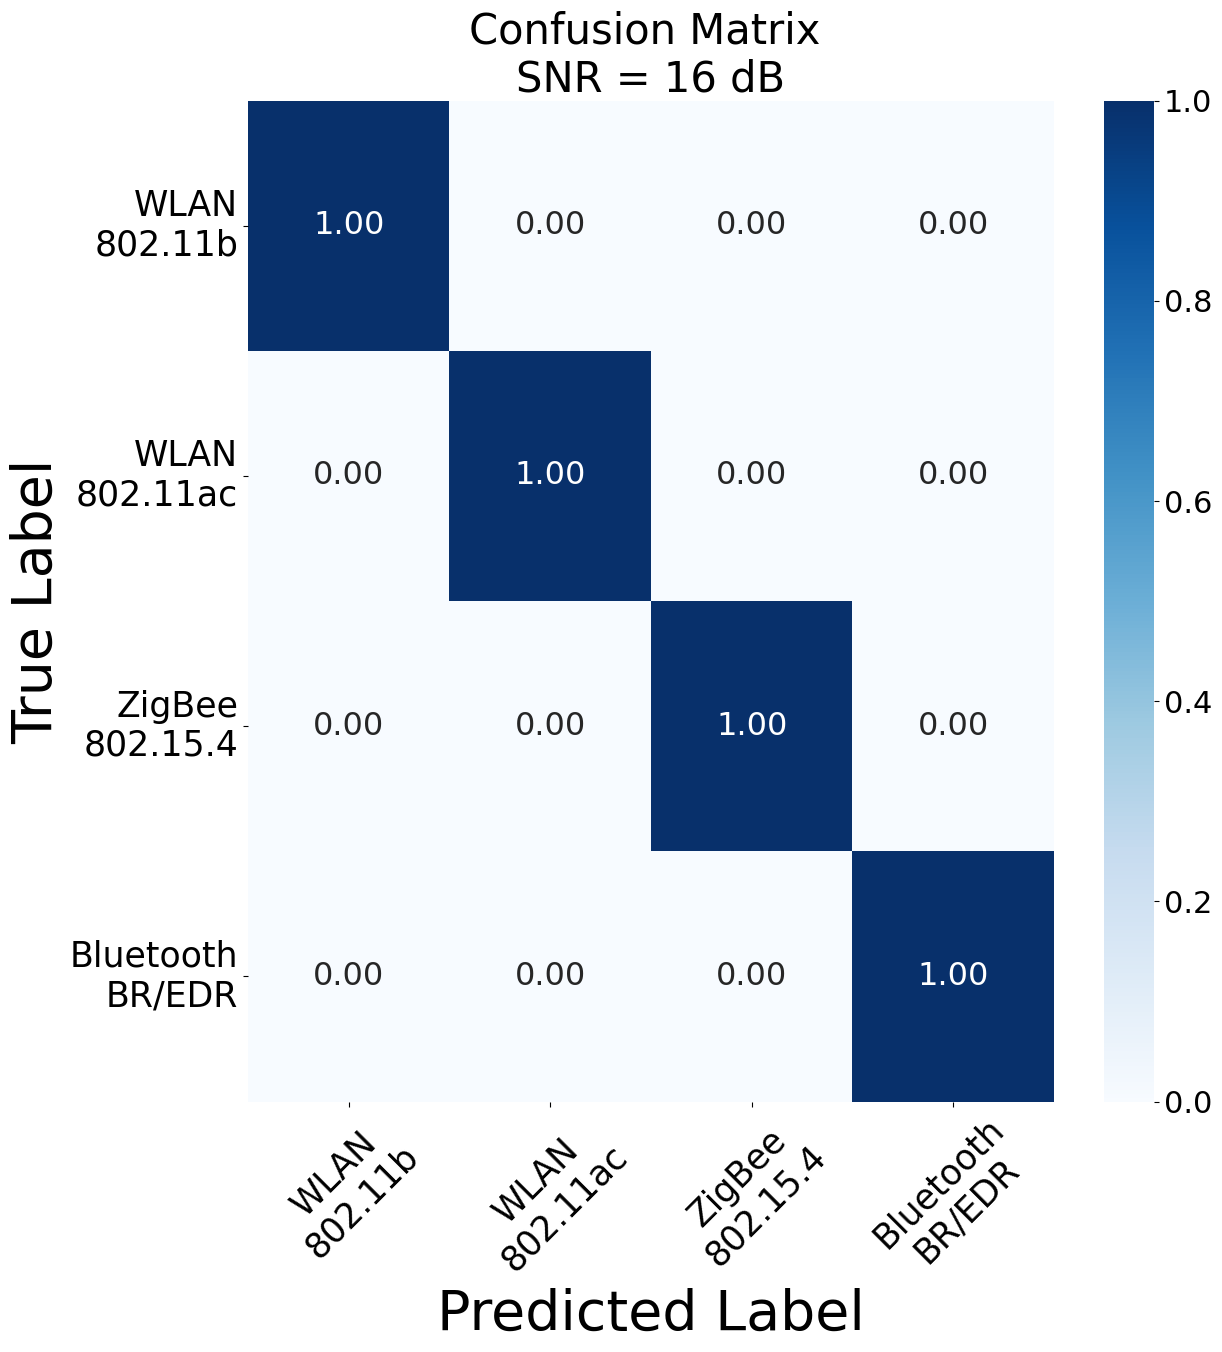

450/450 [==============================] - 2s 5ms/step


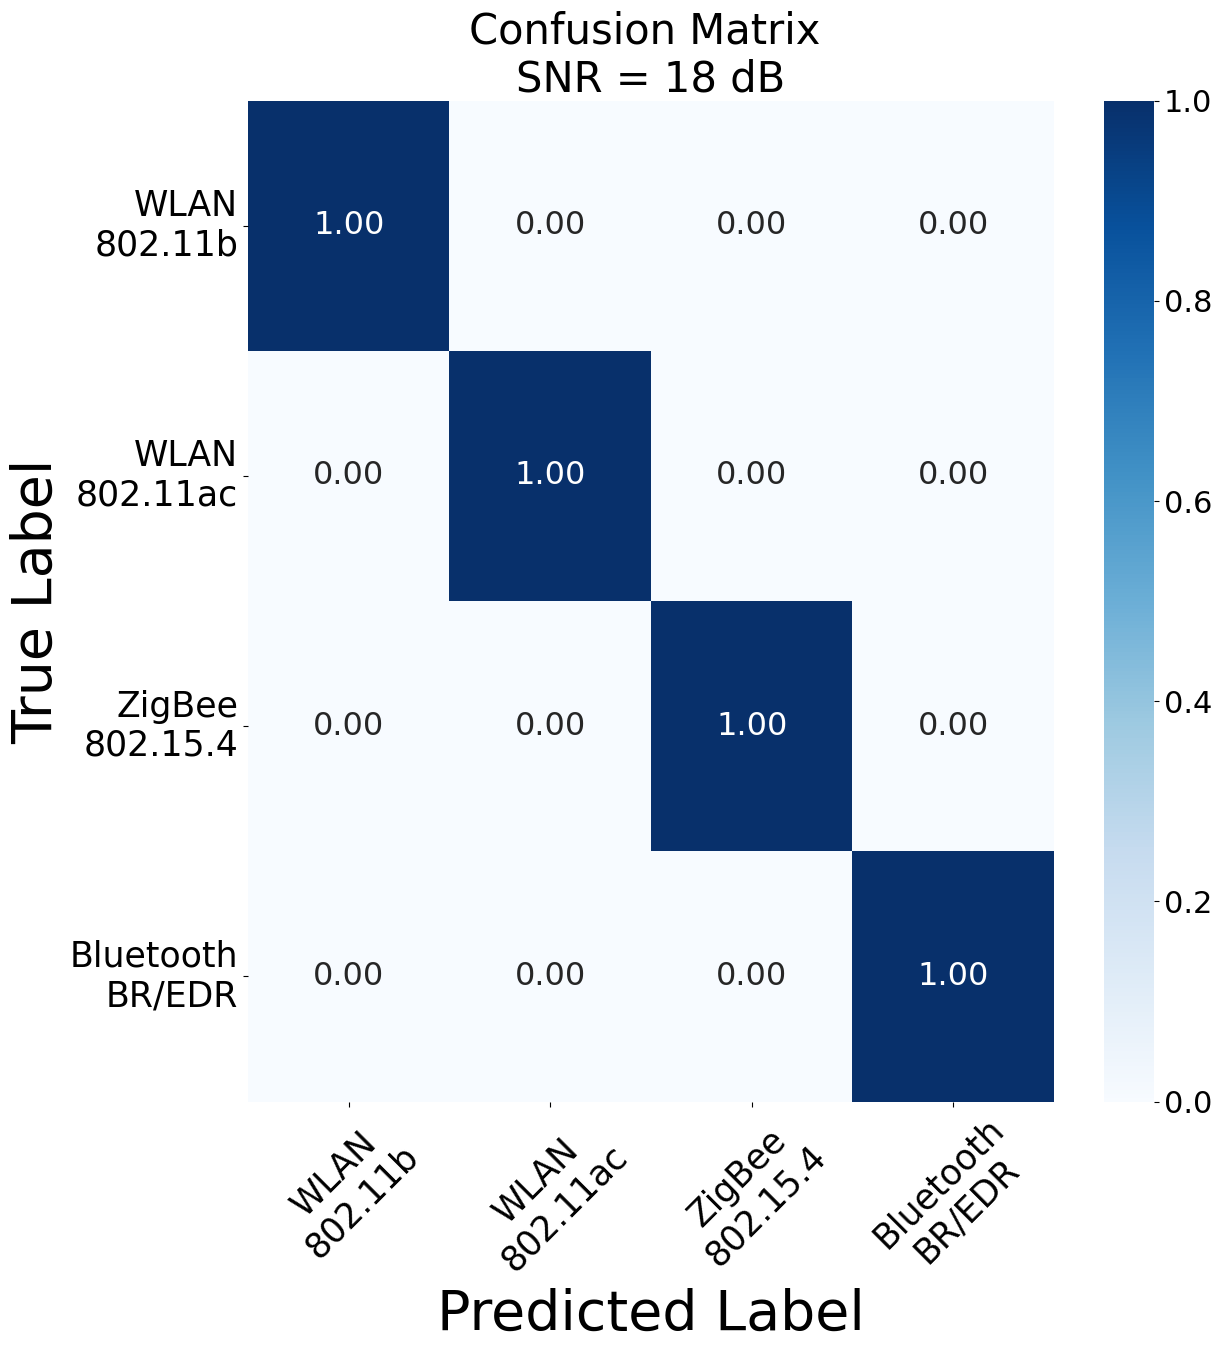

450/450 [==============================] - 2s 5ms/step


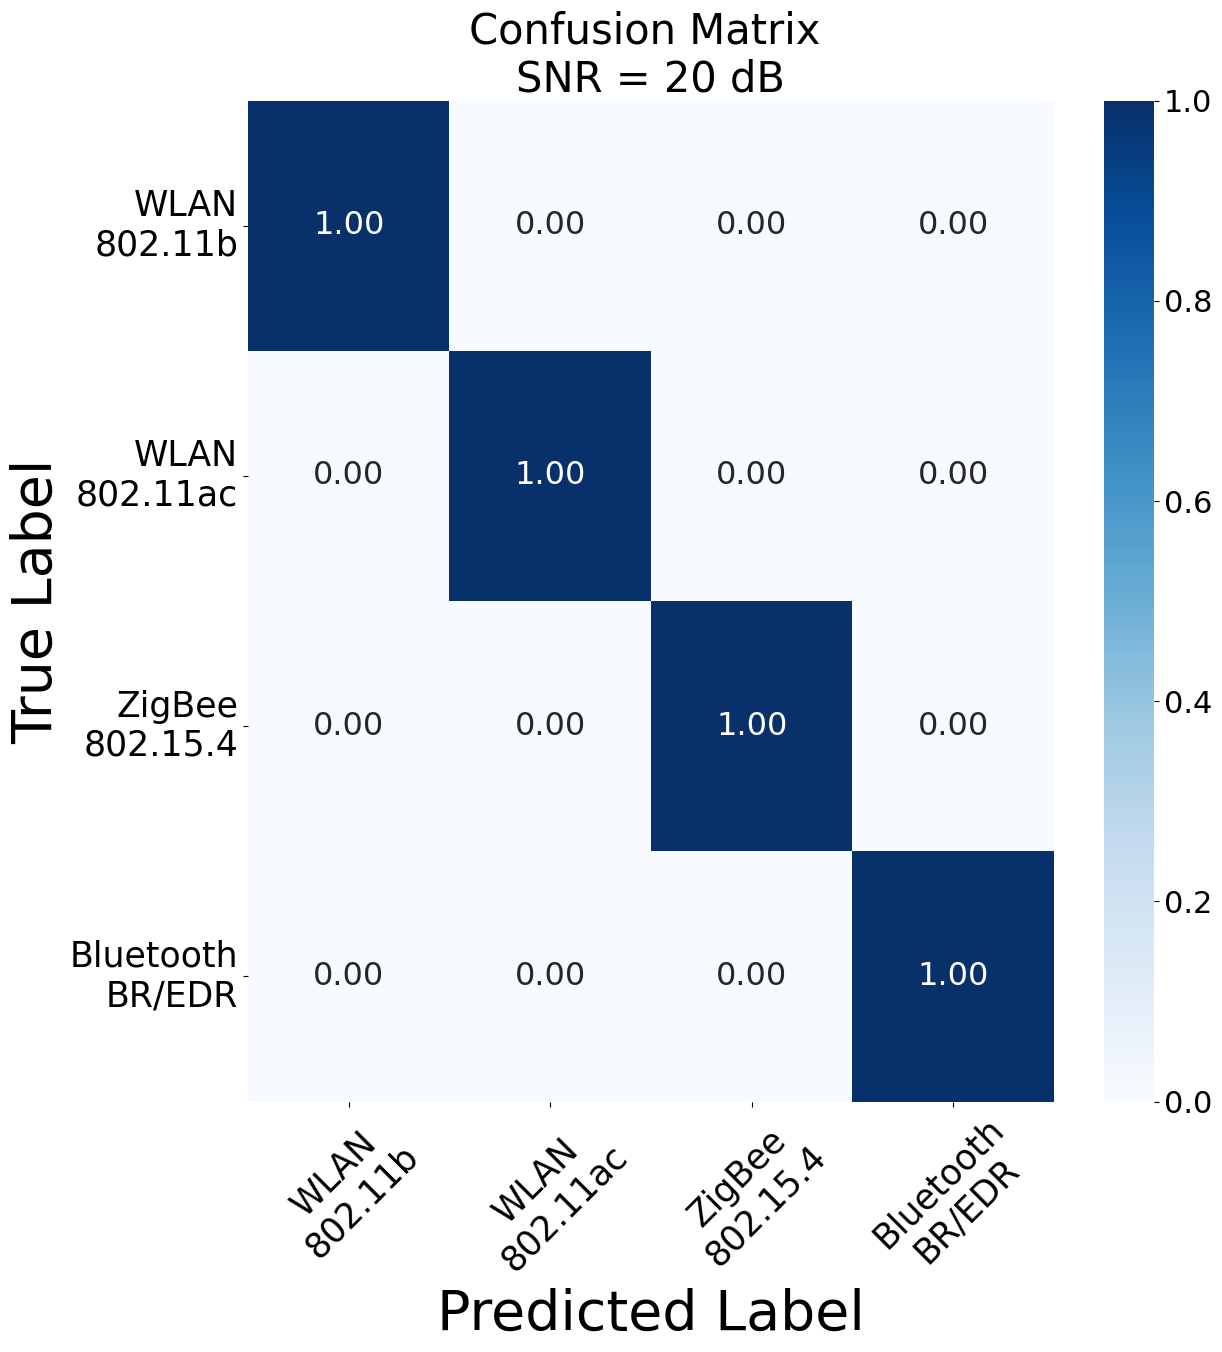

In [ ]:
# Please specify the path where you want to save CMs
CM_path = '/content/drive/MyDrive/ColabNotebooks/RF_classification/Figures/Confusion_Matrix/'

# Set save to False if you dont want to save
CM_full_path = create_directory_for_model(CM_path, model_name, dataset_version, save = False)
# Instead of "SNR" you can specify a list of desired SNR values, for instance: [-6, 0, 6]
SNR_show_confusion_matrix(SNR, lbl_SNR, X_test, model, CM_full_path, save=False)